## **EXP1 Predicting Missing Cell-Types from Bulks using Non-Negative Least Squares Regression Residual**

*This file includes EXP1 analysis and results. Files used were created in preprocessing/EXP1_pseudos notebook.*

**Summary:**
Increasing the number of missing celltypes, using random proportions pseudobulks. Then attempting to extract missing cell type information from residual. 

The residual is calculated in three different ways named: Residual (comparing NNLS calculated proportions to pseudobulks), Residual_diffbase (using different baseline being comapred to), and Residual_realref (using a "real" reference profile for cell lines).

**Hypothesis:**
Deleting cell types from NNLS reference will create a residual from which we can extract missing cell type information. 

**Deconv. Method:**
NNLS

**Factorization Methods:**
SVD, PCA, ICA, NMF

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from openTSNE import TSNE
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# programming stuff
import time
import os, sys
import pickle
from pathlib import Path

These parameters are set in EXP1.py file and can be run through paperpill using run_EXP1.sh file.

In [2]:
#####################
### set the study ###
#####################
#paths:
res_name = f"MCT_snadp_EXP1"
pseudo_name = "MCT_snadp_EXP1_5CTnoise"
files_path = "/data/EXP1/"
cibersort_files = "/data/EXP1/cibersort/CIBERSORTx_Job55_MCT_snadp_EXP1_0_cibersort_sig_inferred_phenoclasses.CIBERSORTx_Job55_MCT_snadp_EXP1_0_cibersort_sig_inferred_refsample.bm.K999.txt"
noise_type = "5CTnoise"
###### set your random seed, num missing cells, and num_samples for reference for reproducibility
random_seed = 88
bulkprop_type = "random"
num_missing_cells = [0, 1, 2, 3]
num_samples = 10000
#how to handle negative residual distribution for NMF
nmf_cut = "minimum_value"
kerne_name = "env_ml"

In [3]:
# Parameters
res_name = "MCT_snadp_EXP1"
pseudo_name = "MCT_snadp_EXP1_noise"
files_path = "/data/EXP1/"
noise_type = "noise"
cibersort_files = "/data/EXP1/cibersort/CIBERSORTx_Job55_MCT_snadp_EXP1_0_cibersort_sig_inferred_phenoclasses.CIBERSORTx_Job55_MCT_snadp_EXP1_0_cibersort_sig_inferred_refsample.bm.K999.txt"
random_seed = 88
num_missing_cells = [0, 1, 2, 3, 4, 8, 12]
num_samples = 10000
nmf_cut = "minimum_value"
kernel_name = "env_ml"


In [4]:
#parameters into paths
actual_path = os.getcwd()
path = f"{actual_path}{files_path}"
aug_data_path = f"{actual_path}{files_path}"
cibersort_path = f"{actual_path}{cibersort_files}"

Import the previously processed datasets. 

*See preprocessing/EXP1_pseudos.ipynb notebook for details.*

In [5]:
#and as anndata object
adata_path = os.path.join(path, f"{res_name}_adata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata = sc.read_h5ad(adata_path)
sn_adata

AnnData object with n_obs × n_vars = 116066 × 28242
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [6]:
Counter(sn_adata.obs["cell_types"])

Counter({'mesothelial cell': 26276,
         'fat cell': 24825,
         'macrophage': 13625,
         'preadipocyte': 26941,
         'endothelial cell': 11480,
         'endothelial cell of lymphatic vessel': 2339,
         'pericyte cell': 1165,
         'T cell': 3022,
         'smooth muscle cell': 2457,
         'B cell': 231,
         'dendritic cell': 679,
         'mast cell': 883,
         'monocyte': 709,
         'stromal cell of endometrium': 284,
         'immature NK T cell': 1073,
         'neutrophil': 77})

In [7]:
#excluding all cell types except 5 of interest
if pseudo_name == "MCT_snadp_EXP1_5CTnoise" or pseudo_name == "MCT_snadp_EXP1_5CTnonoise": #if pseudos have 5 cell types
    exclude = ['preadipocyte',
        'mesothelial cell',
        'pericyte cell',
        'fat cell',
        'endothelial cell',
        'endothelial cell of lymphatic vessel',
        'smooth muscle cell',
        'mast cell',
        'immature NK T cell',
        'stromal cell of endometrium',
        'neutrophil']
    sn_adata = sn_adata[~sn_adata.obs["cell_types"].isin(exclude), :]
#Tilde is “not”, so this reads like “var names that are not in exclude”
print(Counter(sn_adata.obs["cell_types"]))
# define the number of cells and the list of missing cell counts
num_cells = len(sn_adata.obs.cell_types.unique())
cell_order = sn_adata.obs.cell_types.unique()

Counter({'preadipocyte': 26941, 'mesothelial cell': 26276, 'fat cell': 24825, 'macrophage': 13625, 'endothelial cell': 11480, 'T cell': 3022, 'smooth muscle cell': 2457, 'endothelial cell of lymphatic vessel': 2339, 'pericyte cell': 1165, 'immature NK T cell': 1073, 'mast cell': 883, 'monocyte': 709, 'dendritic cell': 679, 'stromal cell of endometrium': 284, 'B cell': 231, 'neutrophil': 77})


Randomly selecting cells to delete:

In [8]:
cells_to_miss = sn_sc_preprocess.select_cells_missing(sn_adata, num_missing_cells, random_seed)
cells_to_miss    

{0: [],
 1: [6],
 2: [12, 6],
 3: [12, 6, 15],
 4: [9, 12, 6, 15],
 8: [1, 5, 6, 9, 11, 12, 14, 15],
 12: [0, 1, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15]}

## Creating reference profiles and Importing Bulks:


1. ref_raw is the sum of each gene expression per num_samples of each cell type. This is not scaled (raw). Once it is clipped and scaled with MinMax(), it becomes:
2. ref_df, which is used in NNLS. 

In [9]:
# Making cell type reference without scaling
cell_types = sn_adata.obs["cell_types"].unique()
gene_ids = sn_adata.var_names
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types)
for cell_type in cell_types:
    cell_df = sn_adata[sn_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw

mesothelial cell  fat cell  macrophage  preadipocyte  \
A1BG                   208.0      17.0       109.0          86.0   
A1BG-AS1               476.0      40.0       393.0         165.0   
A1CF                    14.0      94.0        13.0           9.0   
A2M                   1646.0    2589.0     10126.0        2195.0   
A2M-AS1                 65.0     244.0        98.0         107.0   
...                      ...       ...         ...           ...   
AL049555.1               8.0       0.0         0.0           0.0   
AL109945.1               0.0       2.0         0.0           0.0   
HIST1H3G                 2.0       0.0         0.0           1.0   
PAEP                    14.0       0.0         3.0           4.0   
PLA2G1B                  0.0       0.0         0.0           0.0   

            endothelial cell  endothelial cell of lymphatic vessel  \
A1BG                     8.0                                 101.0   
A1BG-AS1                45.0                                 263.0   
A1CF                    14.0                                  35.0   
A2M                  22561.0                                3863.0   
A2M-AS1                261.0                                 177.0   
...                      ...                                   ...   
AL049555.1               0.0                                   0.0   
AL109945.1               0.0                                   0.0   
HIST1H3G                 2.0                                   0.0   
PAEP                     5.0                                   0.0   
PLA2G1B                  0.0                                   0.0   

            pericyte cell   T cell  smooth muscle cell  B cell  \
A1BG                188.0    127.0               232.0    87.0   
A1BG-AS1            372.0    334.0               397.0   392.0   
A1CF                 10.0     15.0                 9.0     0.0   
A2M               11091.0  11804.0             13430.0  2335.0   
A2M-AS1              66.0   1479.0               109.0   272.0   
...                   ...      ...                 ...     ...   
AL049555.1            0.0      0.0                 0.0     0.0   
AL109945.1            0.0      0.0                 0.0     0.0   
HIST1H3G              0.0      0.0                 2.0     0.0   
PAEP                  8.0      0.0                 9.0     0.0   
PLA2G1B               0.0      0.0                 0.0     0.0   

            dendritic cell  mast cell  monocyte  stromal cell of endometrium  \
A1BG                 206.0      158.0     116.0                        200.0   
A1BG-AS1             679.0      368.0     392.0                        450.0   
A1CF                  27.0        0.0       0.0                          0.0   
A2M                 8063.0    17560.0    2121.0                       2271.0   
A2M-AS1              126.0     2445.0      58.0                         64.0   
...                    ...        ...       ...                          ...   
AL049555.1             0.0        0.0       0.0                          0.0   
AL109945.1             0.0        0.0       0.0                          0.0   
HIST1H3G              21.0        0.0       7.0                          0.0   
PAEP                   0.0        0.0       0.0                          0.0   
PLA2G1B                0.0        0.0       0.0                          0.0   

            immature NK T cell  neutrophil  
A1BG                     123.0         0.0  
A1BG-AS1                 245.0         0.0  
A1CF                       0.0         0.0  
A2M                     7962.0      1256.0  
A2M-AS1                 1137.0         0.0  
...                        ...         ...  
AL049555.1                 0.0         0.0  
AL109945.1                 0.0         0.0  
HIST1H3G                   0.0         0.0  
PAEP                       0.0         0.0  
PLA2G1B                    0.0         0.0  

[28242 rows x 16 columns]

In [10]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw.values
clip_upper = np.quantile(ref_raw_val, 0.95)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = cell_types)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = cell_types)
ref_df

mesothelial cell  fat cell  macrophage  preadipocyte  \
A1BG                0.050254  0.004107    0.026335      0.020778   
A1BG-AS1            0.115004  0.009664    0.094950      0.039865   
A1CF                0.003382  0.022711    0.003141      0.002174   
A2M                 0.397681  0.625513    1.000000      0.530321   
A2M-AS1             0.015704  0.058951    0.023677      0.025852   
...                      ...       ...         ...           ...   
AL049555.1          0.001933  0.000000    0.000000      0.000000   
AL109945.1          0.000000  0.000483    0.000000      0.000000   
HIST1H3G            0.000483  0.000000    0.000000      0.000242   
PAEP                0.003382  0.000000    0.000725      0.000966   
PLA2G1B             0.000000  0.000000    0.000000      0.000000   

            endothelial cell  endothelial cell of lymphatic vessel  \
A1BG                0.001933                              0.024402   
A1BG-AS1            0.010872                              0.063542   
A1CF                0.003382                              0.008456   
A2M                 1.000000                              0.933317   
A2M-AS1             0.063059                              0.042764   
...                      ...                                   ...   
AL049555.1          0.000000                              0.000000   
AL109945.1          0.000000                              0.000000   
HIST1H3G            0.000483                              0.000000   
PAEP                0.001208                              0.000000   
PLA2G1B             0.000000                              0.000000   

            pericyte cell    T cell  smooth muscle cell    B cell  \
A1BG             0.045422  0.030684            0.056052  0.021020   
A1BG-AS1         0.089877  0.080696            0.095917  0.094709   
A1CF             0.002416  0.003624            0.002174  0.000000   
A2M              1.000000  1.000000            1.000000  0.564146   
A2M-AS1          0.015946  0.357333            0.026335  0.065716   
...                   ...       ...                 ...       ...   
AL049555.1       0.000000  0.000000            0.000000  0.000000   
AL109945.1       0.000000  0.000000            0.000000  0.000000   
HIST1H3G         0.000000  0.000000            0.000483  0.000000   
PAEP             0.001933  0.000000            0.002174  0.000000   
PLA2G1B          0.000000  0.000000            0.000000  0.000000   

            dendritic cell  mast cell  monocyte  stromal cell of endometrium  \
A1BG              0.049770   0.038173  0.028026                     0.048321   
A1BG-AS1          0.164049   0.088910  0.094709                     0.108722   
A1CF              0.006523   0.000000  0.000000                     0.000000   
A2M               1.000000   1.000000  0.512443                     0.548683   
A2M-AS1           0.030442   0.590722  0.014013                     0.015463   
...                    ...        ...       ...                          ...   
AL049555.1        0.000000   0.000000  0.000000                     0.000000   
AL109945.1        0.000000   0.000000  0.000000                     0.000000   
HIST1H3G          0.005074   0.000000  0.001691                     0.000000   
PAEP              0.000000   0.000000  0.000000                     0.000000   
PLA2G1B           0.000000   0.000000  0.000000                     0.000000   

            immature NK T cell  neutrophil  
A1BG                  0.029717    0.000000  
A1BG-AS1              0.059193    0.000000  
A1CF                  0.000000    0.000000  
A2M                   1.000000    0.303455  
A2M-AS1               0.274704    0.000000  
...                        ...         ...  
AL049555.1            0.000000    0.000000  
AL109945.1            0.000000    0.000000  
HIST1H3G              0.000000    0.000000  
PAEP                  0.000000    0.000000  
PLA2G1B               0.000000    0.000000  

[28242 rows x 16 column

Importing Bulks:

In [11]:
#each pseudo file has:
## realisitc*200, cell_type_specific*1000*, random*200, equal*200
#so here we're defining the ranges to extract the bulks of choice.
bulk_range = dict()
bulk_range["realistic"] = range(0,200)
bulk_range["cell_type_specific"] = range(200,(50*num_cells)+200) #1000
bulk_range["random"] = range((50*num_cells)+200,(50*num_cells)+400) #1200
bulk_range["equal"] = range((50*num_cells)+400,(50*num_cells)+600) #1400
bulk_range["all"] = range(0,(50*num_cells)+600)

In [12]:
num_cell_type_specific = 50 * int(sn_adata.obs["cell_types"].unique().shape[0])
num_bulks = 200+num_cell_type_specific+200+200
num_bulks

1400

In [13]:
#importing bulks to deconvolve
X_full, Y_full, gene_df, meta_df = sn_sc_preprocess.read_all_pseudobulk_files(data_path=aug_data_path, noise_type= f"{noise_type}_", file_name = res_name, num_bulks_training = num_bulks, num_files=10, random_selection=False)
X_full.index = meta_df.index
Y_full.index = meta_df.index

0
1


2


3


4


5


6


7


8


9


(8000, 2)
(8000, 2)


/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_3843/1540599639.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


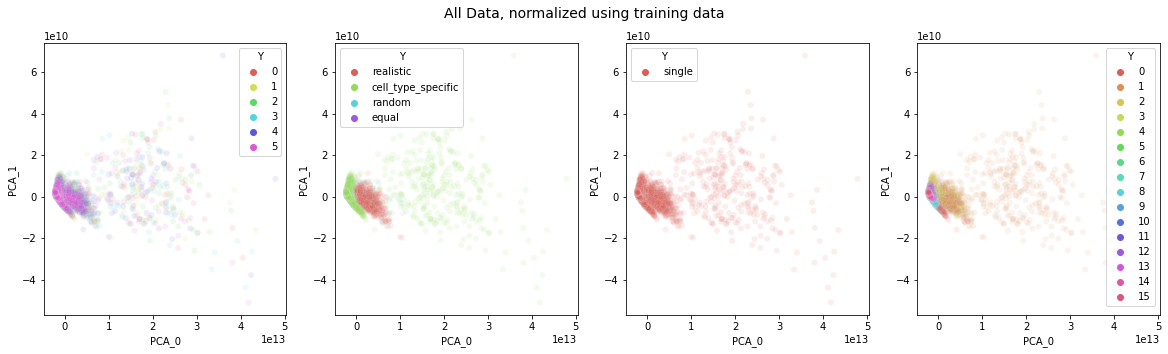

In [14]:
## plot samples (some of them for speed)
X_temp = X_full.iloc[0:8000]
Y_temp_p = Y_full.iloc[0:8000]
meta_temp = meta_df.iloc[0:8000]

plot_df = vp.get_pca_for_plotting(X_temp)

fig, axs = plt.subplots(1, 4, figsize=(20,5))

Y_temp = np.copy(Y_temp_p)
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_pca(plot_df, meta_temp.sample_id.to_numpy(), axs[0], title=f"")
vp.plot_pca(plot_df, meta_temp.cell_prop_type.to_numpy(), axs[1], title=f"")
vp.plot_pca(plot_df, meta_temp.samp_type.to_numpy(), axs[2], title=f"")
vp.plot_pca(plot_df, Y_temp, axs[3], title=f"")

fig.suptitle("All Data, normalized using training data", fontsize=14)

fig.show()

In [15]:
#cut to only the random samples
idx_interest = np.where(meta_df.cell_prop_type == bulkprop_type)[0]
pseudo_df = X_full.iloc[idx_interest]
prop_df = Y_full.iloc[idx_interest]
pseudo_df.index = range(0,len(pseudo_df))
prop_df.index = pseudo_df.index
meta_df.index = meta_df.index
pseudo_df.columns = sn_adata.var_names
pseudo_df

A1BG      A1BG-AS1        A1CF           A2M        A2M-AS1  \
0      4029.136077  14576.559758   34.635611  1.300901e+07   29158.466217   
1     13408.097566  41611.572294    0.000000  8.967957e+06   48976.890372   
2      4129.526053  19649.576074    0.000000  1.205904e+07  103624.306650   
3      2415.564445  14559.072585    0.000000  1.552095e+07   55685.013851   
4      5208.878089  47909.431262  139.211668  1.802839e+07   61666.624634   
...            ...           ...         ...           ...            ...   
1995   3178.082287  27622.360677    8.554888  2.058438e+07   87665.459165   
1996   2790.357902  21727.969525   38.849137  1.553986e+07  104324.636479   
1997   6816.302955  43966.560509    0.000000  2.791042e+07  315184.817984   
1998   4831.318102  36661.568574   12.111576  6.375042e+06   66265.333805   
1999   2909.283597  22218.876802   19.198549  1.793856e+07   87145.791415   

            A2ML1      A2ML1-AS1     A3GALT2         A4GALT      A4GNT  ...  \
0      829.921000  163946.846705  240.685398  125148.249388   0.000000  ...   
1     4594.264530  330919.573952  253.976598   32813.287024   0.000000  ...   
2      264.960754   61583.372307   33.424792    9610.273871   1.616078  ...   
3     1765.549950  156952.659869  147.997303   13945.592427   0.000000  ...   
4     4176.053578  387764.444125  967.862512   54419.821385   4.373932  ...   
...           ...            ...         ...            ...        ...  ...   
1995   866.294314  266805.300033  235.563666   26688.133201   0.000000  ...   
1996  1573.034316  448343.220528  212.495989   73549.840284  32.670816  ...   
1997  2016.524786  125749.015591  185.251805   15838.194116   0.000000  ...   
1998   367.766149   87578.153208   75.161018   12561.158276   0.000000  ...   
1999   452.462692  190167.548110  199.702359   20041.335495   2.332109  ...   

      AP003550.1  AC005544.2  AC025674.2  AC105924.1  AC239803.3  AL049555.1  \
0       1.089617    0.000000         0.0    0.000000    0.000000         0.0   
1       0.000000    8.747467         0.0    1.226277    4.796209         0.0   
2       1.778429    0.000000         0.0    1.672300    0.829564         0.0   
3       1.814275    0.000000         0.0    0.000000    0.000000         0.0   
4       0.000000    0.000000         0.0    0.000000    1.561844         0.0   
...          ...         ...         ...         ...         ...         ...   
1995    3.401390    0.000000         0.0   12.792165    1.973921         0.0   
1996    0.000000    5.649327         0.0    0.000000    0.000000         0.0   
1997    0.000000    0.000000         0.0    0.000000    0.000000         0.0   
1998    0.946468    0.000000         0.0    1.664259    0.000000         0.0   
1999    0.000000    0.000000         0.0    0.000000    0.000000         0.0   

      AL109945.1  HIST1H3G      PAEP  PLA2G1B  
0            0.0  2.099350  2.020950      0.0  
1            0.0  0.000000  2.474075      0.0  
2            0.0  1.725380  0.802388      0.0  
3            0.0  0.000000  0.000000      0.0  
4            0.0  0.000000  6.247629      0.0  
...          ...       ...       ...      ...  
1995         0.0  7.026532  0.000000      0.0  
1996         0.0  1.222352  4.865945      0.0  
1997         0.0  0.000000  0.000000      0.0  
1998         0.0  0.000000  0.000000      0.0  
1999         0.0  0.000000  1.976343      0.0  

[2000 rows x 28242 columns]

In [16]:
#cutting to 1000 pseudos w/ random seed
random.seed(seed=random_seed)
idx_to_keep = np.random.choice(pseudo_df.index, 1000, replace=False)
#cutting both props and pseudos
pseudo_df = pseudo_df.iloc[idx_to_keep]
prop_df = prop_df.iloc[idx_to_keep]
pseudo_df

A1BG      A1BG-AS1        A1CF           A2M        A2M-AS1  \
1059  3890.106270  29258.266934   43.410204  1.595368e+07   79928.585428   
929   4431.683887  32302.174742  169.489352  1.146490e+07   22367.380258   
1506  2444.374490  22424.136567   21.814173  2.280616e+07  141202.670687   
237   8046.822731  32085.139593  122.678411  2.653369e+07  131409.469619   
1371  8250.598372  36705.962846   21.031406  2.806997e+07   81552.991896   
...           ...           ...         ...           ...            ...   
1573  4468.806967  38868.049376   46.841855  1.978609e+07  155909.901229   
1132  4338.624197  26997.667534  223.462740  1.047296e+07  124245.421706   
1998  4831.318102  36661.568574   12.111576  6.375042e+06   66265.333805   
1988  9110.801233  23635.548945   46.397272  6.568068e+06   17158.507937   
1167  3013.585932  29459.821035   11.492387  7.360234e+06    6817.677183   

            A2ML1      A2ML1-AS1     A3GALT2         A4GALT      A4GNT  ...  \
1059  1792.835134  155030.171162  124.654933   16701.442581  25.836646  ...   
929    834.522876  175639.825406  114.428584   31778.748504   0.000000  ...   
1506  1042.883048  127986.839468   69.037490   25693.392528   4.129166  ...   
237   2110.644639  137040.727044   83.286323   11209.816741   0.000000  ...   
1371   527.521263  176966.699268  115.774148   22491.723589   0.000000  ...   
...           ...            ...         ...            ...        ...  ...   
1573   471.042979   79179.024416   87.685569   12074.056961   0.000000  ...   
1132   186.756808   73551.230116   96.098095   13495.637443   0.000000  ...   
1998   367.766149   87578.153208   75.161018   12561.158276   0.000000  ...   
1988   558.966679  255066.089145  204.457202  121378.289317   0.000000  ...   
1167  1837.251280  113292.836685  199.074608   11861.806073   7.462069  ...   

      AP003550.1  AC005544.2  AC025674.2  AC105924.1  AC239803.3  AL049555.1  \
1059    0.000000         0.0         0.0    0.000000    0.000000         0.0   
929     0.000000         0.0         0.0    1.900550    0.000000         0.0   
1506    0.000000         0.0         0.0    0.824458    0.000000         0.0   
237     0.000000         0.0         0.0    0.000000    0.000000         0.0   
1371    0.000000         0.0         0.0    1.107024    0.000000         0.0   
...          ...         ...         ...         ...         ...         ...   
1573   11.922797         0.0         0.0    1.100488    0.000000         0.0   
1132    0.000000         0.0         0.0    0.000000    0.000000         0.0   
1998    0.946468         0.0         0.0    1.664259    0.000000         0.0   
1988    0.000000         0.0         0.0    0.000000    0.000000         0.0   
1167    0.000000         0.0         0.0    0.000000    3.671186         0.0   

      AL109945.1  HIST1H3G      PAEP  PLA2G1B  
1059         0.0  2.156318  0.000000      0.0  
929          0.0  0.000000  0.000000      0.0  
1506         0.0  5.201266  6.176404      0.0  
237          0.0  0.000000  0.000000      0.0  
1371         0.0  4.475423  0.000000      0.0  
...          ...       ...       ...      ...  
1573         0.0  6.292247  0.898452      0.0  
1132         0.0  0.000000  0.000000      0.0  
1998         0.0  0.000000  0.000000      0.0  
1988         0.0  2.285284  0.000000      0.0  
1167         0.0  0.000000  7.821895      0.0  

[1000 rows x 28242 columns]

In [17]:
#clippign before scaling to 95th pecentile
pseudo_copy = pseudo_df.copy() #keeping genes
pseudo_df = pseudo_df.values #np array
clip_upper = np.quantile(pseudo_df, 0.95)
pseudo_df = np.clip(pseudo_df, 0, clip_upper)
#and normalize to values between 0 and 1
scaler = MinMaxScaler()
scaler.fit(pseudo_df)
normalized_pseudo_df = scaler.transform(pseudo_df)
normalized_pseudo_df = pd.DataFrame(normalized_pseudo_df, 
                            columns = pseudo_copy.columns, index= pseudo_copy.index)
normalized_pseudo_df      

A1BG  A1BG-AS1      A1CF  A2M   A2M-AS1     A2ML1  A2ML1-AS1  \
1059  0.247716  0.395014  0.016521  1.0  0.152780  0.219466   0.130450   
929   0.285961  0.439679  0.064506  1.0  0.037335  0.092157   0.149673   
1506  0.145623  0.294733  0.008302  1.0  0.275671  0.119837   0.105225   
237   0.541251  0.436495  0.046690  1.0  0.256030  0.261686   0.113670   
1371  0.555641  0.504299  0.008004  1.0  0.156037  0.051373   0.150911   
...        ...       ...       ...  ...       ...       ...        ...   
1573  0.288582  0.536025  0.017827  1.0  0.305168  0.043870   0.059701   
1132  0.279389  0.361843  0.085047  1.0  0.241661  0.006104   0.054452   
1998  0.314182  0.503648  0.004610  1.0  0.125377  0.030150   0.067535   
1988  0.616386  0.312509  0.017658  1.0  0.026888  0.055551   0.223757   
1167  0.185819  0.397972  0.004374  1.0  0.006148  0.225367   0.091520   

       A3GALT2    A4GALT     A4GNT  ...  AP003550.1  AC005544.2  AC025674.2  \
1059  0.110286  0.054348  0.067057  ...    0.000000         0.0         0.0   
929   0.101238  0.116309  0.000000  ...    0.000000         0.0         0.0   
1506  0.061080  0.091301  0.010717  ...    0.000000         0.0         0.0   
237   0.073686  0.031779  0.000000  ...    0.000000         0.0         0.0   
1371  0.102429  0.078143  0.000000  ...    0.000000         0.0         0.0   
...        ...       ...       ...  ...         ...         ...         ...   
1573  0.077578  0.035331  0.000000  ...    0.231859         0.0         0.0   
1132  0.085021  0.041173  0.000000  ...    0.000000         0.0         0.0   
1998  0.066497  0.037333  0.000000  ...    0.018406         0.0         0.0   
1988  0.180889  0.484526  0.000000  ...    0.000000         0.0         0.0   
1167  0.176127  0.034459  0.019367  ...    0.000000         0.0         0.0   

      AC105924.1  AC239803.3  AL049555.1  AL109945.1  HIST1H3G      PAEP  \
1059    0.000000    0.000000         0.0         0.0  0.010261  0.000000   
929     0.046124    0.000000         0.0         0.0  0.000000  0.000000   
1506    0.020008    0.000000         0.0         0.0  0.024751  0.061655   
237     0.000000    0.000000         0.0         0.0  0.000000  0.000000   
1371    0.026866    0.000000         0.0         0.0  0.021297  0.000000   
...          ...         ...         ...         ...       ...       ...   
1573    0.026707    0.000000         0.0         0.0  0.029943  0.008969   
1132    0.000000    0.000000         0.0         0.0  0.000000  0.000000   
1998    0.040389    0.000000         0.0         0.0  0.000000  0.000000   
1988    0.000000    0.000000         0.0         0.0  0.010875  0.000000   
1167    0.000000    0.048946         0.0         0.0  0.000000  0.078080   

      PLA2G1B  
1059      0.0  
929       0.0  
1506      0.0  
237       0.0  
1371      0.0  
...       ...  
1573      0.0  
1132      0.0  
1998      0.0  
1988      0.0  
1167      0.0  

[1000 rows x 28242 columns]

In [18]:
# read in cibersort genes 
cibersort_df = pd.read_csv(cibersort_path, sep="\t")
cibersort_genes = cibersort_df["NAME"].values.tolist()
#and set intersection of gene_ids and cibersort:
gene_notin = np.setdiff1d(gene_ids, cibersort_genes)
#keep genes in both and check number
gene_ids = [ele for ele in gene_ids if ele not in gene_notin]
len(gene_ids)     

2757

In [19]:
#cutting to cibersort genes 
pseudo_copy  = pseudo_copy[gene_ids]
ref_raw = ref_raw.loc[gene_ids,:]
ref_df = ref_df.loc[gene_ids,:]
normalized_pseudo_df = normalized_pseudo_df[gene_ids]
normalized_pseudo_df

AAGAB      AASS     AATBC      AATF      ABAT    ABCA10     ABCA8  \
1059  0.634839  0.093451  0.010204  0.300739  0.347421  1.000000  1.000000   
929   0.198879  0.036742  0.005104  0.289371  0.316089  0.487317  0.693984   
1506  0.395460  0.055095  0.004166  0.342140  0.093950  1.000000  0.570031   
237   0.148760  0.049201  0.007172  0.343119  0.047609  1.000000  1.000000   
1371  0.197573  0.044850  0.022429  0.367066  0.114866  0.244417  0.807420   
...        ...       ...       ...       ...       ...       ...       ...   
1573  0.352070  0.073235  0.011059  0.414168  0.118532  0.221001  0.948840   
1132  0.149103  0.018193  0.010724  0.287557  0.098597  0.218192  0.118564   
1998  0.363291  0.059834  0.003201  0.235724  0.156356  0.340524  1.000000   
1988  0.227854  0.092330  0.001590  0.181339  0.148243  1.000000  1.000000   
1167  0.160410  0.073864  0.004743  0.045013  0.126176  1.000000  1.000000   

         ABCA9     ABCB1    ABCB10  ...    NMNAT3     NMRK1      NMT2  \
1059  1.000000  0.047700  0.317104  ...  0.205677  0.346523  0.572341   
929   1.000000  0.022304  0.112712  ...  0.100736  0.154426  0.211892   
1506  1.000000  0.118479  0.189238  ...  0.076019  0.055405  0.284409   
237   0.982635  0.004137  0.335607  ...  0.082312  0.041709  0.360912   
1371  1.000000  0.016321  0.174046  ...  0.101125  0.208852  0.215566   
...        ...       ...       ...  ...       ...       ...       ...   
1573  0.360697  0.114283  0.162333  ...  0.066978  0.148285  0.178922   
1132  0.342749  0.032242  0.108404  ...  0.043627  0.116684  0.296259   
1998  0.680437  0.074564  0.081714  ...  0.102073  0.084824  0.073062   
1988  1.000000  0.082669  0.139889  ...  0.094232  0.160157  0.201699   
1167  1.000000  0.058074  0.118160  ...  0.117329  0.093103  0.068164   

         NMUR1      NNMT     NOC3L      NOCT      NOD2     NOL4L      NOL7  
1059  0.065383  0.499237  0.502588  0.235783  0.045645  0.146611  0.475656  
929   0.011982  0.103371  0.126890  0.101027  0.085382  0.064863  0.289553  
1506  0.092780  0.166387  0.317338  0.075628  0.026655  0.257646  0.270905  
237   0.006069  0.151940  0.259777  0.066842  0.015777  0.098095  0.208724  
1371  0.003480  0.039051  0.202965  0.107466  0.065596  0.132254  0.547003  
...        ...       ...       ...       ...       ...       ...       ...  
1573  0.033942  0.161527  0.395097  0.080577  0.023491  0.328677  0.279721  
1132  0.021824  0.049910  0.178319  0.094888  0.021218  0.169881  0.138129  
1998  0.003613  0.225343  0.440327  0.089668  0.021074  0.055004  0.172516  
1988  0.006797  0.317409  0.536390  0.112529  0.011025  0.096127  0.343482  
1167  0.004863  0.255156  0.153784  0.056815  0.068763  0.031974  0.154474  

[1000 rows x 2757 columns]

TSNEs of Pseuboulks and References:

===> Finding 180 nearest neighbors using Annoy approximate search using euclidean distance...


   --> Time elapsed: 0.65 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=1.00, lr=1000.00 for 500 iterations...


Iteration   50, KL divergence 1.2838, 50 iterations in 0.2732 sec


Iteration  100, KL divergence 1.2645, 50 iterations in 0.2238 sec


Iteration  150, KL divergence 1.2611, 50 iterations in 0.2177 sec


Iteration  200, KL divergence 1.2603, 50 iterations in 0.2153 sec


Iteration  250, KL divergence 1.2604, 50 iterations in 0.2171 sec


Iteration  300, KL divergence 1.2606, 50 iterations in 0.2162 sec


Iteration  350, KL divergence 1.2606, 50 iterations in 0.2165 sec


Iteration  400, KL divergence 1.2608, 50 iterations in 0.2156 sec


Iteration  450, KL divergence 1.2608, 50 iterations in 0.2159 sec


Iteration  500, KL divergence 1.2609, 50 iterations in 0.2165 sec
   --> Time elapsed: 2.23 seconds
===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...


   --> Time elapsed: 0.42 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 9748.9192, 50 iterations in 0.0299 sec
Iteration  100, KL divergence 9567.6107, 50 iterations in 0.0285 sec
Iteration  150, KL divergence 9475.1368, 50 iterations in 0.0289 sec
Iteration  200, KL divergence 9426.5363, 50 iterations in 0.0286 sec
Iteration  250, KL divergence 9391.8521, 50 iterations in 0.0284 sec
   --> Time elapsed: 0.14 seconds
===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimi

Perplexity value 60 is too high. Using perplexity 5.00 instead


Iteration  100, KL divergence 72.4180, 50 iterations in 0.0145 sec
Iteration  150, KL divergence 72.3332, 50 iterations in 0.0142 sec
Iteration  200, KL divergence 72.2865, 50 iterations in 0.0140 sec
Iteration  250, KL divergence 72.1093, 50 iterations in 0.0134 sec
   --> Time elapsed: 0.07 seconds
===> Finding 15 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.00, lr=16.00 for 500 iterations...


Iteration   50, KL divergence 0.0909, 50 iterations in 0.2250 sec
Iteration  100, KL divergence 0.0468, 50 iterations in 0.1969 sec


Iteration  150, KL divergence 0.0465, 50 iterations in 0.1940 sec
Iteration  200, KL divergence 0.0484, 50 iterations in 0.1936 sec


Iteration  250, KL divergence 0.0467, 50 iterations in 0.1953 sec
Iteration  300, KL divergence 0.0459, 50 iterations in 0.1944 sec


Iteration  350, KL divergence 0.0458, 50 iterations in 0.2004 sec


Iteration  400, KL divergence 0.0455, 50 iterations in 0.2148 sec


Iteration  450, KL divergence 0.0454, 50 iterations in 0.2133 sec


Iteration  500, KL divergence 0.0453, 50 iterations in 0.2110 sec
   --> Time elapsed: 2.04 seconds
===> Finding 15 nearest neighbors in existing embedding using exact search...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 69.0521, 50 iterations in 0.0214 sec
Iteration  100, KL divergence 63.2247, 50 iterations in 0.0239 sec
Iteration  150, KL divergence 58.2218, 50 iterations in 0.0212 sec
Iteration  200, KL divergence 54.8923, 50 iterations in 0.0211 sec
Iteration  250, KL divergence 53.9723, 50 iterations in 0.0204 sec
   --> Time elapsed: 0.11 seconds
===> Finding 15 nearest neighbors in existing embedding using exact search...
   --> Time elapsed: 0.02 seconds
===> Calculating affinity matrix...
   --> Ti

Iteration  100, KL divergence 8130.2069, 50 iterations in 0.0316 sec
Iteration  150, KL divergence 7977.1154, 50 iterations in 0.0307 sec
Iteration  200, KL divergence 7884.7230, 50 iterations in 0.0310 sec
Iteration  250, KL divergence 7855.0330, 50 iterations in 0.0342 sec
   --> Time elapsed: 0.16 seconds


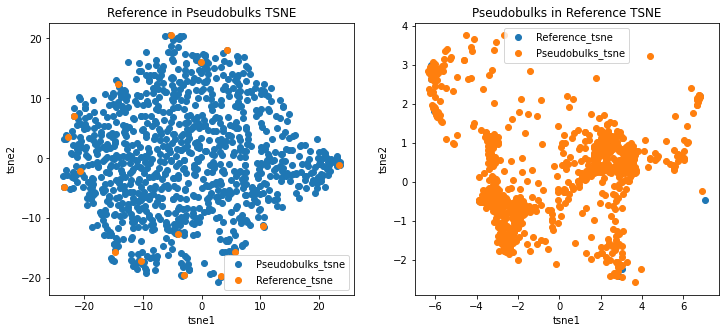

In [20]:
#tsne plots of reference dataframes projected in normalized pseudobulks TSNE 
#figures
plt.figure(figsize=(12, 5))
#data used
x_train = normalized_pseudo_df.values
x_test = ref_df.T.values
#compute the affinities between data points
affinities_train = affinity.PerplexityBasedNN(
    x_train,
    perplexity=60,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
#initialize coordinates for embedd.
init_train = initialization.pca(x_train, random_state=42)
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    verbose=True,
)
#optimize embedding
embedding_train = embedding_train.optimize(n_iter=500)
#transform both in train embedd.
tsne_train = embedding_train.transform(x_train)
tsne_test = embedding_train.transform(x_test)
plt.subplot(1, 2, 1)
plt.scatter(tsne_train[:,0], tsne_train[:,1], label = "Pseudobulks_tsne" )
plt.scatter(tsne_test[:,0], tsne_test[:,1], label = "Reference_tsne" )
plt.title(f"Reference in Pseudobulks TSNE")
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.legend()
#data used (switching)
x_train = ref_df.T.values
x_test = normalized_pseudo_df.values
#compute the affinities between data points
affinities_train = affinity.PerplexityBasedNN(
    x_train,
    perplexity=60,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)
#initialize coordinates for embedd.
init_train = initialization.pca(x_train, random_state=42)
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
    negative_gradient_method="fft",
    n_jobs=8,
    verbose=True,
)
#optimize embedding
embedding_train = embedding_train.optimize(n_iter=500)
#transform both in train embedd.
tsne_train = embedding_train.transform(x_train)
tsne_test = embedding_train.transform(x_test)
plt.subplot(1, 2, 2)
plt.scatter(tsne_train[:,0], tsne_train[:,1], label = "Reference_tsne" )
plt.scatter(tsne_test[:,0], tsne_test[:,1], label = "Pseudobulks_tsne" )
plt.title(f"Pseudobulks in Reference TSNE")
plt.xlabel("tsne1")
plt.ylabel("tsne2")
plt.legend()
plt.show()

In [21]:
# Putting together all reference expression, scaled and unscaled, and props.
all_refs = dict()
all_prop_refs = dict()
all_prop_refs_rebalanced = dict()
all_refs_raw = dict()
all_refs_av = dict()
#with no cell missing is just ref_df
all_refs[0] = ref_df
all_refs_raw[0] = ref_raw
all_prop_refs[0] = prop_df
all_prop_refs_rebalanced[0] = prop_df
#assigning the rest in a loop
for num in num_missing_cells[1:]:
    #dropping cell types missing from references
    all_refs[num] = ref_df.drop(ref_df.columns[cells_to_miss[num]], axis=1)
    all_refs_raw[num] = ref_raw.drop(ref_raw.columns[cells_to_miss[num]], axis=1)
    all_prop_refs[num] = prop_df.drop(prop_df.columns[cells_to_miss[num]], axis=1) 
    all_prop_refs_rebalanced[num] = all_prop_refs[num]
    for idx,sample in all_prop_refs_rebalanced[num].iterrows():
        tot = np.sum(sample) #making them equal 1
        sample = sample / tot

## NNLS Deconvolution:

In [22]:
calc_prop_tot, calc_res_tot, custom_res_tot, comparison_prop_tot, missing_cell_tot  = vp.calc_nnls(all_refs, prop_df, normalized_pseudo_df, num_missing_cells, cells_to_miss)

Exp 0


Exp 1


Exp 2


Exp 3


Exp 4


Exp 8


Exp 12


Evalutating NNLS Performance:

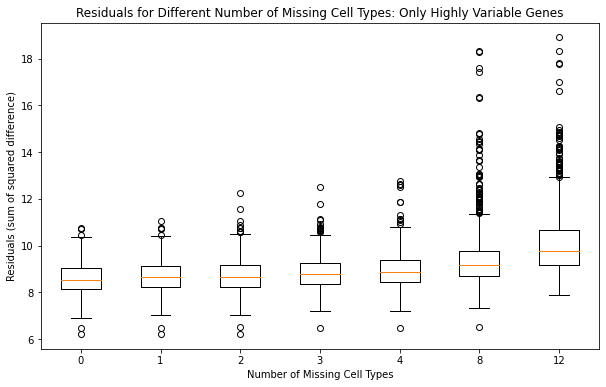

In [23]:
#Distribution of residuals as the sum of squared difference from NNLS
residuals = [calc_res_tot[exp] for exp in num_missing_cells]

plt.figure(figsize=(10, 6))
plt.boxplot(residuals, labels=num_missing_cells)
plt.xlabel('Number of Missing Cell Types')
plt.ylabel('Residuals (sum of squared difference)')
plt.title('Residuals for Different Number of Missing Cell Types: Only Highly Variable Genes')
## nnls(A, b)
## /Ax -b/^2
plt.show()

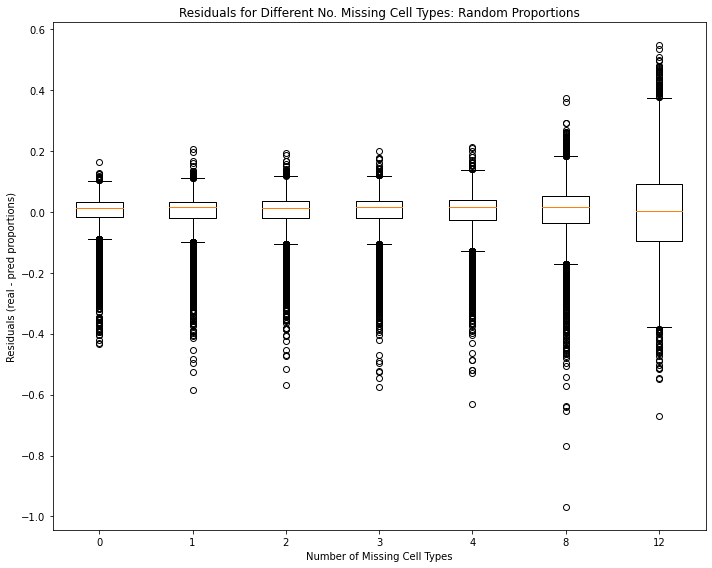

In [24]:
#Distribution of residuals as the difference between calculated and real proportions.
fig, ax = plt.subplots(figsize=(10, 8))

# List to store all the residual values
residual_values = []

# Iterate over the dataframes and extract the residual values
for num_cells in num_missing_cells:
    df = custom_res_tot[num_cells]
    residuals = df.values.flatten()  # Flatten the dataframe to a 1D array
    residual_values.append(residuals)

# Plot the box and whisker plot for all the residuals
ax.boxplot(residual_values, labels=num_missing_cells)
ax.set_title("Residuals for Different No. Missing Cell Types: Random Proportions")
ax.set_xlabel("Number of Missing Cell Types")
ax.set_ylabel("Residuals (real - pred proportions)")

plt.tight_layout()
plt.show()

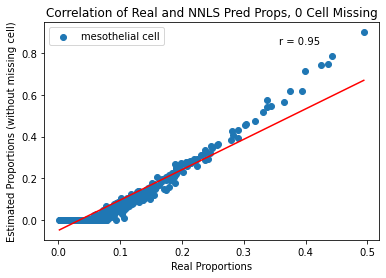

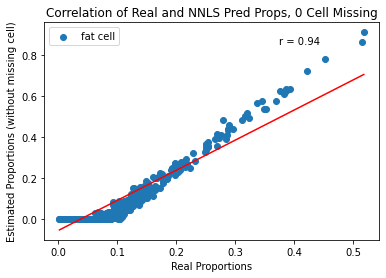

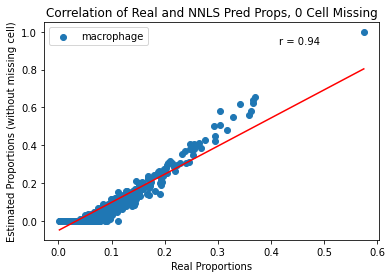

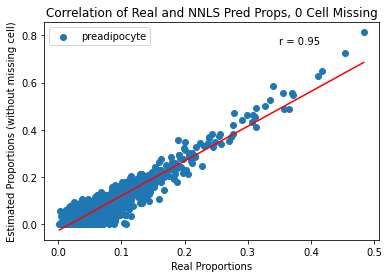

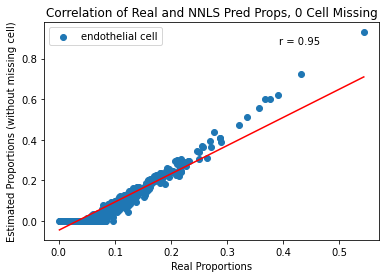

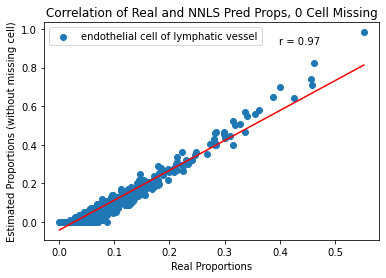

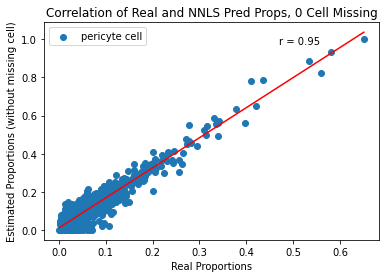

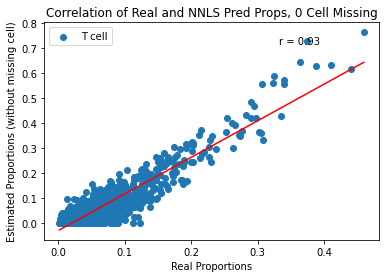

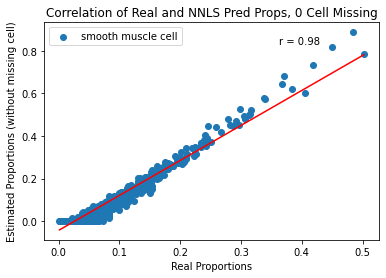

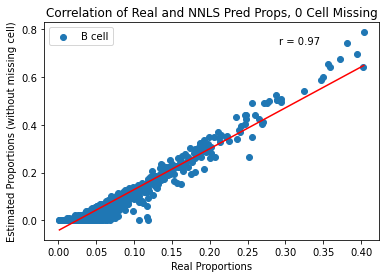

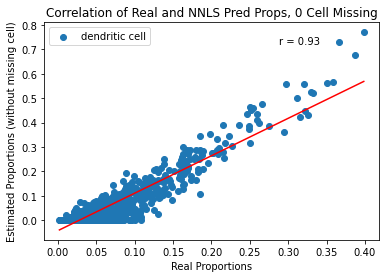

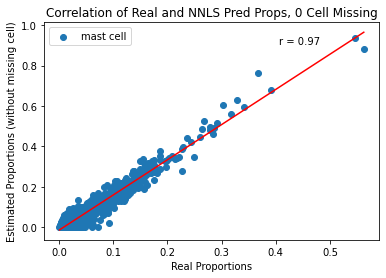

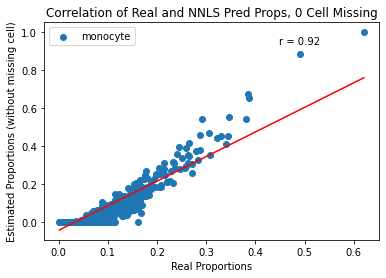

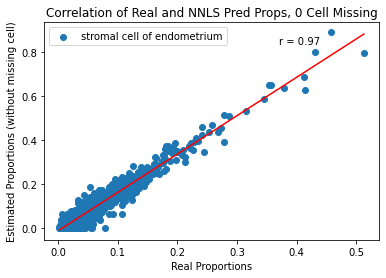

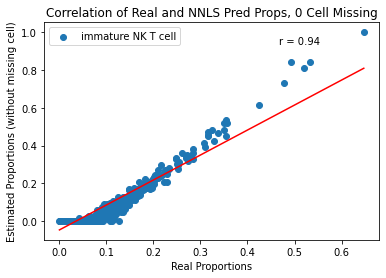

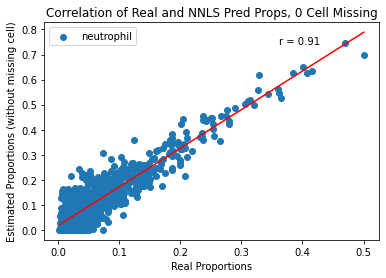

In [25]:
#Evaluation performance with no cell types missing, expect to be very close to 1.
num = 0 
for col_cell in all_prop_refs[num].columns:
    x = all_prop_refs_rebalanced[num][col_cell].values.astype(float)
    y = calc_prop_tot[num][col_cell].values.astype(float)
    correlation_coefficient = np.corrcoef(x, y)[0,1]
    plt.scatter(x, y, label= f"{col_cell}")
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color = "red")
    r, p = stats.pearsonr(x, y)
    plt.annotate('r = {:.2f}'.format(r), xy=(0.7, 0.9), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and NNLS Pred Props, {num} Cell Missing')
    plt.legend()
    plt.show()

Real Proportions shape: (1000, 16)
Estimated Proportions shape: (1000, 16)


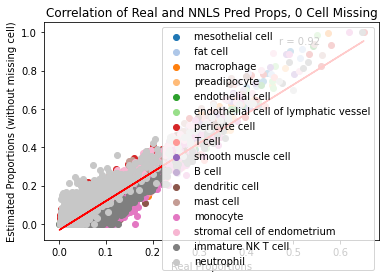

Real Proportions shape: (1000, 15)
Estimated Proportions shape: (1000, 15)


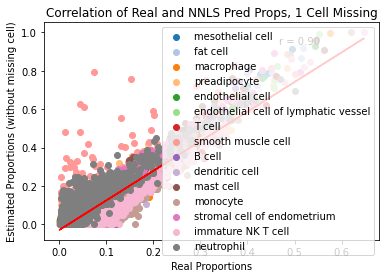

Real Proportions shape: (1000, 14)
Estimated Proportions shape: (1000, 14)


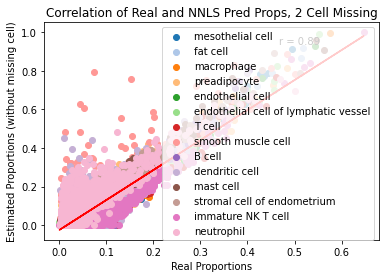

Real Proportions shape: (1000, 13)
Estimated Proportions shape: (1000, 13)


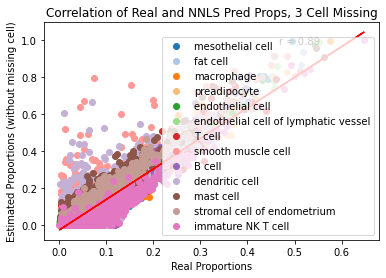

Real Proportions shape: (1000, 12)
Estimated Proportions shape: (1000, 12)


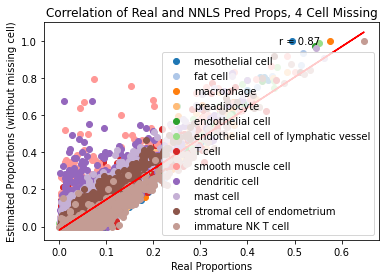

Real Proportions shape: (1000, 8)
Estimated Proportions shape: (1000, 8)


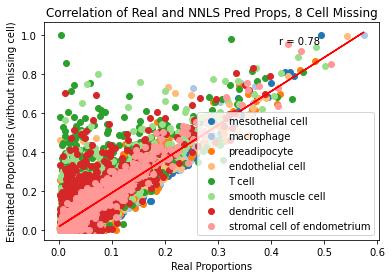

Real Proportions shape: (1000, 4)
Estimated Proportions shape: (1000, 4)


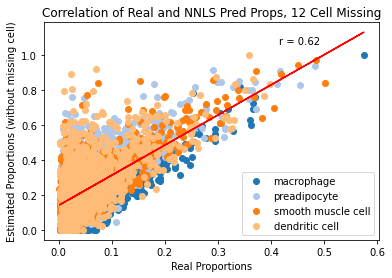

In [26]:
# define colormap for coloring cell types
cmap = get_cmap('tab20') 
for num in num_missing_cells:
    real_proportions = all_prop_refs_rebalanced[num].values.astype(float) #real proportions of present cells
    estimated_proportions = calc_prop_tot[num].values.astype(float) #estimated proportions of present cells.
    cell_types = all_prop_refs[num].columns.tolist() 
    # Print the shapes of the matrices
    print("Real Proportions shape:", real_proportions.shape)
    print("Estimated Proportions shape:", estimated_proportions.shape)
    correlation_coefficient = np.corrcoef(real_proportions, estimated_proportions)[0, 1]
    #scatter plot with colored points for each cell type
    fig, ax = plt.subplots()
    for i, cell_type in enumerate(cell_types):
        x = real_proportions[:, i]
        y = estimated_proportions[:, i]
        color = cmap(i)  #unique color for each cell type
        ax.scatter(x, y, label=cell_type, color=color)
    #fit a regression line
    m, b = np.polyfit(real_proportions.flatten(), estimated_proportions.flatten(), 1)
    plt.plot(real_proportions.flatten(), m * real_proportions.flatten() + b, color="red")
    r, p = stats.pearsonr(real_proportions.flatten(), estimated_proportions.flatten())
    plt.annotate(f'r = {r:.2f}', xy=(0.7, 0.9), xycoords='axes fraction')
    plt.xlabel('Real Proportions')
    plt.ylabel('Estimated Proportions (without missing cell)')
    plt.title(f'Correlation of Real and NNLS Pred Props, {num} Cell Missing')
    plt.legend(loc='best')  #show the cell type labels in the legend
    plt.show()

Recreate Matrices:

In [27]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
recreated_mat_all = dict()
for num in num_missing_cells:
        recreated_mat_all[num] = pd.DataFrame(all_refs[num] @ calc_prop_tot[num].T)
        recreated_mat_all[num] = recreated_mat_all[num].T
        recreated_mat_all[num].columns = gene_ids
recreated_mat_all[0]    

AAGAB      AASS     AATBC      AATF      ABAT    ABCA10     ABCA8  \
0    0.344623  0.245477  0.014658  0.465840  0.283213  0.599885  0.608311   
1    0.337739  0.143715  0.020775  0.463565  0.334658  0.397384  0.415771   
2    0.312094  0.175063  0.002713  0.398250  0.185073  0.503413  0.470877   
3    0.215530  0.164243  0.006777  0.329644  0.175221  0.545216  0.483712   
4    0.302492  0.170547  0.024341  0.422843  0.274748  0.444758  0.512461   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.377712  0.142011  0.002596  0.490382  0.202133  0.436707  0.467198   
996  0.313934  0.104117  0.005589  0.432822  0.216787  0.387191  0.271151   
997  0.284630  0.233616  0.008075  0.415030  0.231545  0.531276  0.552331   
998  0.325423  0.260517  0.009075  0.446564  0.198441  0.596781  0.548170   
999  0.216879  0.257350  0.004746  0.274236  0.231013  0.561377  0.672094   

        ABCA9     ABCB1    ABCB10  ...    NMNAT3     NMRK1      NMT2  \
0    0.754520  0.105991  0.284337  ...  0.270125  0.326256  0.534799   
1    0.607379  0.044067  0.256299  ...  0.247136  0.343779  0.458358   
2    0.477618  0.280703  0.225456  ...  0.133986  0.239936  0.508385   
3    0.549778  0.045945  0.178476  ...  0.163653  0.137933  0.628344   
4    0.635942  0.052904  0.281340  ...  0.230326  0.265403  0.472355   
..        ...       ...       ...  ...       ...       ...       ...   
995  0.422655  0.300903  0.272760  ...  0.127663  0.349090  0.597250   
996  0.323005  0.188470  0.200259  ...  0.111309  0.276509  0.634674   
997  0.365451  0.217675  0.190807  ...  0.275439  0.216662  0.546664   
998  0.435206  0.153741  0.248511  ...  0.289933  0.276011  0.521039   
999  0.489004  0.147024  0.173918  ...  0.224153  0.204043  0.332820   

        NMUR1      NNMT     NOC3L      NOCT      NOD2     NOL4L      NOL7  
0    0.041791  0.365310  0.235572  0.205421  0.065993  0.265260  0.259829  
1    0.006654  0.243351  0.214541  0.200360  0.101243  0.207419  0.249329  
2    0.071569  0.249875  0.189204  0.132931  0.032688  0.428991  0.239691  
3    0.010409  0.236073  0.170998  0.116375  0.032785  0.251735  0.192202  
4    0.011330  0.236462  0.201142  0.185385  0.078774  0.229985  0.230243  
..        ...       ...       ...       ...       ...       ...       ...  
995  0.024931  0.206922  0.231980  0.118614  0.025914  0.556102  0.290119  
996  0.016962  0.174651  0.169173  0.114851  0.049655  0.465938  0.248059  
997  0.013053  0.463712  0.365259  0.135143  0.033141  0.228725  0.284195  
998  0.010518  0.472939  0.393568  0.203501  0.027378  0.183002  0.314256  
999  0.009384  0.467241  0.238673  0.128215  0.067986  0.094849  0.228558  

[1000 rows x 2757 columns]

## **Extracting Missing Cell Information:**

In [28]:
# Get the corresponding missing_cell_proportions
missing_cell_prop = dict()
missing_cell_prop[0] = []
for num in num_missing_cells[1:]:
    missing_cell_prop[num] = prop_df[missing_cell_tot[num].columns]  

## **Calculate Residuals:**

1. Residual uses:

pseudobulks - recreated_mat_all (reference used normalized (all_refs) * calculated proportions (calc_prop_tot))



In [29]:
#Residual as the the difference between the recreated matrix and pseudobulks.
residuals = dict()
for num in num_missing_cells:
    res = normalized_pseudo_df.values - recreated_mat_all[num].values
    residuals[num] = pd.DataFrame(res, columns = gene_ids)
residuals[0]    

AAGAB      AASS     AATBC      AATF      ABAT    ABCA10     ABCA8  \
0    0.290216 -0.152026 -0.004454 -0.165101  0.064208  0.400115  0.391689   
1   -0.138860 -0.106973 -0.015671 -0.174194 -0.018569  0.089932  0.278213   
2    0.083366 -0.119968  0.001453 -0.056110 -0.091123  0.496587  0.099154   
3   -0.066770 -0.115042  0.000395  0.013475 -0.127612  0.454784  0.516288   
4   -0.104919 -0.125697 -0.001913 -0.055777 -0.159882 -0.200340  0.294959   
..        ...       ...       ...       ...       ...       ...       ...   
995 -0.025641 -0.068776  0.008464 -0.076214 -0.083601 -0.215705  0.481642   
996 -0.164832 -0.085925  0.005135 -0.145265 -0.118191 -0.168999 -0.152587   
997  0.078661 -0.173782 -0.004874 -0.179306 -0.075189 -0.190752  0.447669   
998 -0.097569 -0.168186 -0.007485 -0.265226 -0.050198  0.403219  0.451830   
999 -0.056469 -0.183486 -0.000003 -0.229222 -0.104837  0.438623  0.327906   

        ABCA9     ABCB1    ABCB10  ...    NMNAT3     NMRK1      NMT2  \
0    0.245480 -0.058292  0.032767  ... -0.064449  0.020267  0.037543   
1    0.392621 -0.021762 -0.143587  ... -0.146399 -0.189353 -0.246466   
2    0.522382 -0.162224 -0.036218  ... -0.057967 -0.184531 -0.223976   
3    0.432857 -0.041809  0.157131  ... -0.081341 -0.096224 -0.267432   
4    0.364058 -0.036583 -0.107294  ... -0.129201 -0.056551 -0.256789   
..        ...       ...       ...  ...       ...       ...       ...   
995 -0.061958 -0.186620 -0.110428  ... -0.060685 -0.200805 -0.418328   
996  0.019744 -0.156228 -0.091855  ... -0.067682 -0.159825 -0.338415   
997  0.314986 -0.143111 -0.109093  ... -0.173366 -0.131838 -0.473602   
998  0.564794 -0.071071 -0.108621  ... -0.195701 -0.115854 -0.319340   
999  0.510996 -0.088949 -0.055758  ... -0.106824 -0.110940 -0.264656   

        NMUR1      NNMT     NOC3L      NOCT      NOD2     NOL4L      NOL7  
0    0.023591  0.133927  0.267016  0.030362 -0.020348 -0.118648  0.215827  
1    0.005328 -0.139980 -0.087651 -0.099334 -0.015861 -0.142556  0.040223  
2    0.021211 -0.083488  0.128134 -0.057302 -0.006033 -0.171345  0.031215  
3   -0.004341 -0.084134  0.088778 -0.049533 -0.017008 -0.153641  0.016522  
4   -0.007850 -0.197411  0.001823 -0.077919 -0.013178 -0.097730  0.316759  
..        ...       ...       ...       ...       ...       ...       ...  
995  0.009012 -0.045396  0.163117 -0.038037 -0.002422 -0.227425 -0.010397  
996  0.004862 -0.124740  0.009146 -0.019964 -0.028437 -0.296057 -0.109929  
997 -0.009440 -0.238369  0.075067 -0.045475 -0.012067 -0.173721 -0.111679  
998 -0.003721 -0.155531  0.142822 -0.090971 -0.016353 -0.086875  0.029226  
999 -0.004521 -0.212085 -0.084889 -0.071400  0.000777 -0.062875 -0.074084  

[1000 rows x 2757 columns]

## **Singular Value Decomposition**

SVD on each residual matrix. For this purposes, we will only focus on U and S.

U: Left singular vectors, representing the column space of the original matrix. (cells)

Σ or sigma: Singular values, representing the diagonal matrix of singular values.

Vh or V^T: Right singular vectors, representing the row space of the original matrix. (sample)

Calculating SVD

In [30]:
num_cells_missing = num_missing_cells #for each number of missing cells
num_celltypes = len(sn_adata.obs['cell_types'].unique())

In [31]:
# SVD on pseudobulk for QC
df = normalized_pseudo_df
Mat_pseudo = df.astype("float32")
U_pseudo, s_pseudo, V_pseudo = sp.linalg.svd(Mat_pseudo)
U_pseudo = pd.DataFrame(U_pseudo)
s_pseudo = pd.DataFrame(s_pseudo)
V_pseudo = pd.DataFrame(V_pseudo)

In [32]:
# SVD on residual 1
U_all = dict()
s_all = dict()
V_all = dict()
Matres_all = dict()

for num in num_cells_missing:
    df = residuals[num]
    Mat = df.astype("float32")
    U, s, V = sp.linalg.svd(Mat)
    U = pd.DataFrame(U)
    s = pd.DataFrame(s)
    V = pd.DataFrame(V)

    U_all[num] = U
    s_all[num] = s
    V_all[num] = V
    Matres_all[num] = Mat

In [33]:
#SVD on reference for QC
U_all_ref = dict()
s_all_ref = dict()
V_all_ref = dict()
Matref_all_ref = dict()

for num in num_cells_missing:
    df = all_refs[num]
    Mat_ref  = df.astype("float32")
    U_ref , s_ref , V_ref  = sp.linalg.svd(Mat_ref )
    U_ref = pd.DataFrame(U_ref )
    s_ref  = pd.DataFrame(s_ref )
    V_ref  = pd.DataFrame(V_ref )

    U_all_ref[num] = U_ref 
    s_all_ref[num] = s_ref 
    V_all_ref[num] = V_ref 
    Matref_all_ref[num] = Mat_ref 

In [34]:
#SVD on recreated matrix for QC
U_all_rec = dict()
s_all_rec = dict()
V_all_rec = dict()
Matres_all_rec = dict()

for num in num_cells_missing:
    df = recreated_mat_all[num]
    Mat_rec = df.astype("float32")
    U_rec , s_rec , V_rec  = sp.linalg.svd(Mat_rec )
    U_rec  = pd.DataFrame(U_rec )
    s_rec  = pd.DataFrame(s_rec )
    V_rec  = pd.DataFrame(V_rec )

    U_all_rec[num] = U_rec 
    s_all_rec[num] = s_rec 
    V_all_rec[num] = V_rec 
    Matres_all_rec[num] = Mat_rec 

S-Value Eval for each SVD:

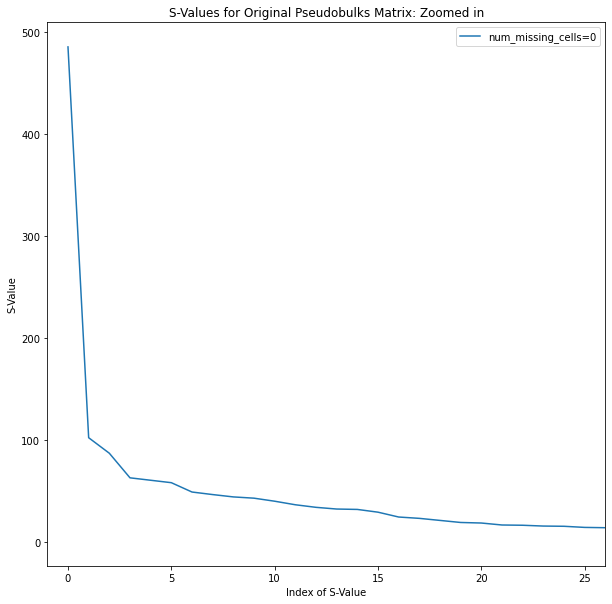

In [35]:
###SVD on Pseudobulk##
num =0
plt.figure(figsize = [10,10])
# Create a color map
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
dataframe = pd.DataFrame(s_pseudo)
x = dataframe.index
y = dataframe.values.flatten()
color = color_map(num_missing_cells.index(num))
label = f"num_missing_cells={num}"
plt.plot(x, y, color=color, label=label)

# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Original Pseudobulks Matrix: Zoomed in')
plt.xlim([-1,num_celltypes + 10])
# Add a legend
plt.legend()
# Display the plot
plt.show()

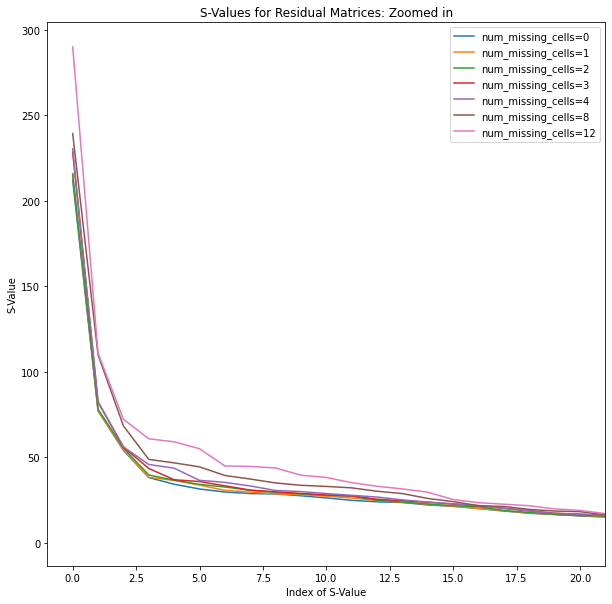

In [36]:
plt.figure(figsize = [10,10])
# Create a color map for differentiating num 
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
for num in num_missing_cells:
    dataframe = s_all[num]
    x = dataframe.index
    y = dataframe.values.flatten()
    color = color_map(num_missing_cells.index(num))
    label = f"num_missing_cells={num}"
    plt.plot(x, y, color=color, label=label)
# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Residual Matrices: Zoomed in')
plt.xlim([-1,num_celltypes + 5])
# Add a legend
plt.legend()
# Display the plot
plt.show()

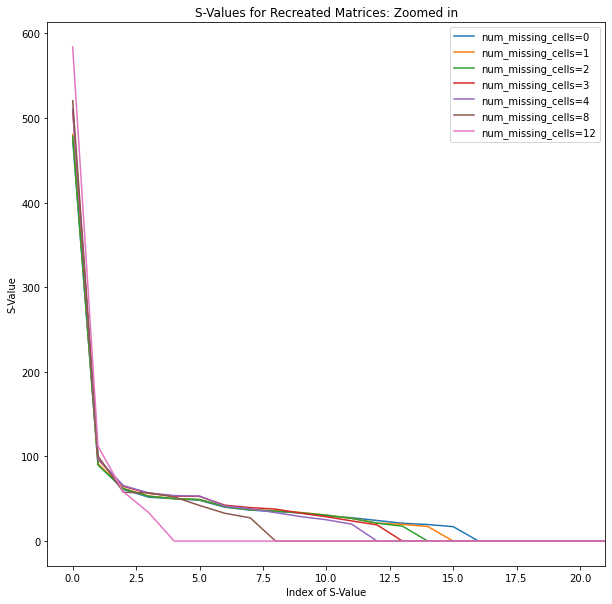

In [37]:
plt.figure(figsize = [10,10])
# Create a color map for differentiating the dataframes
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
for num in num_missing_cells:
    dataframe = s_all_rec[num]
    x = dataframe.index
    y = dataframe.values.flatten()
    color = color_map(num_missing_cells.index(num))
    label = f"num_missing_cells={num}"
    plt.plot(x, y, color=color, label=label)

# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Recreated Matrices: Zoomed in')
plt.xlim([-1,num_celltypes + 5])
# Add a legend
plt.legend()
# Display the plot
plt.show()

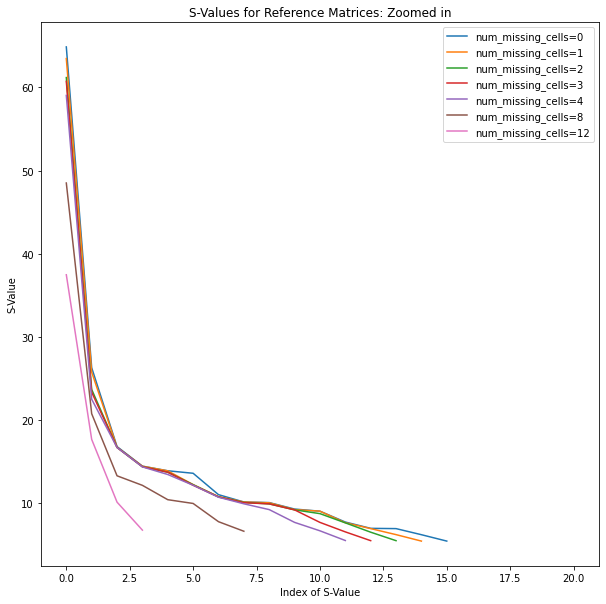

In [38]:
plt.figure(figsize = [10,10])
# Create a color map for differentiating the dataframes
color_map = plt.cm.get_cmap('tab10')
# Plotting the scatterplots
for num in num_missing_cells:
    dataframe = s_all_ref[num]
    x = dataframe.index
    y = dataframe.values.flatten()
    color = color_map(num_missing_cells.index(num))
    label = f"num_missing_cells={num}"
    plt.plot(x, y, color=color, label=label)

# Set labels and title
plt.xlabel('Index of S-Value')
plt.ylabel('S-Value')
plt.title('S-Values for Reference Matrices: Zoomed in')
plt.xlim([-1,num_celltypes + 5])
# Add a legend
plt.legend()
# Display the plot
plt.show()

**Reconstructing Residual Matrix**

In [39]:
#reconstructing SVD using all only some S values, Residual 1.
Recon_Mat_matchS = dict()
for num in num_cells_missing:
    num_SVs = num + 1 #num of comp
    #cutting S and U to 30 to match elbow plots
    U = U_all[num].values[:, :num_SVs]
    S = np.zeros((U.shape[1], Matres_all[num].shape[0]))
    diag_val = s_all[num].values[:num_SVs]
    np.fill_diagonal(S, [diag_val])
    anum = U @ S #reconstructing
    #saving to df dict
    Recon_Mat_matchS[num] = pd.DataFrame(anum[:,0:num_SVs])

**Plotting Correlations between SVD on Residual and Missing Cell Information:**

**Residual** 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


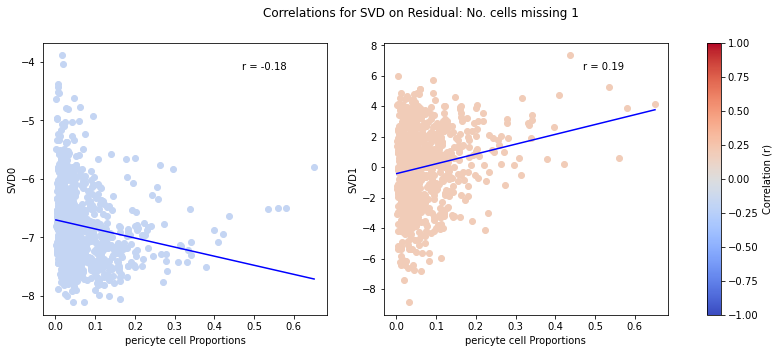

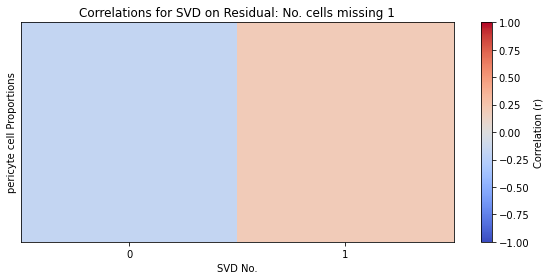

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


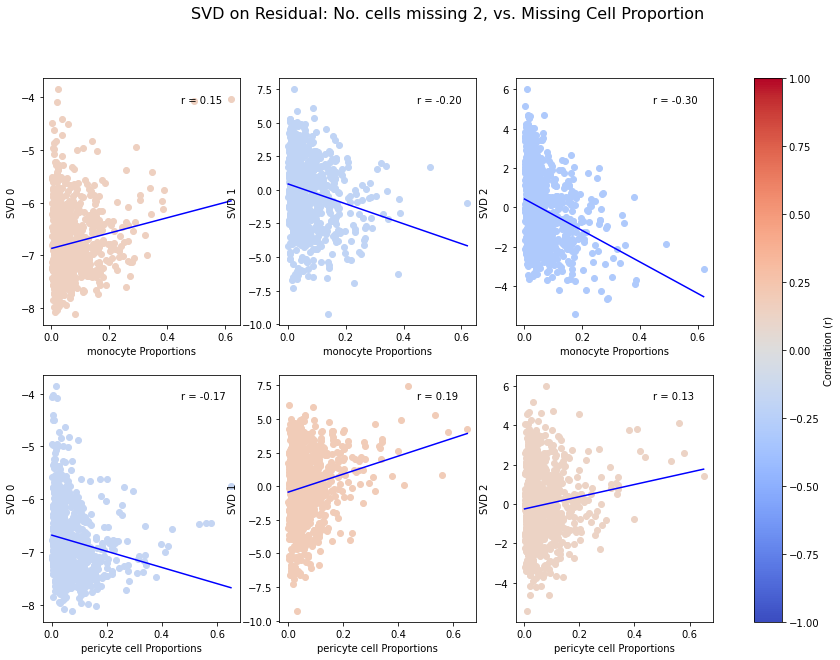

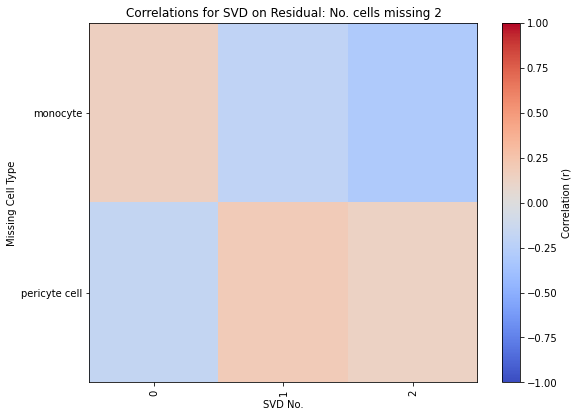

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


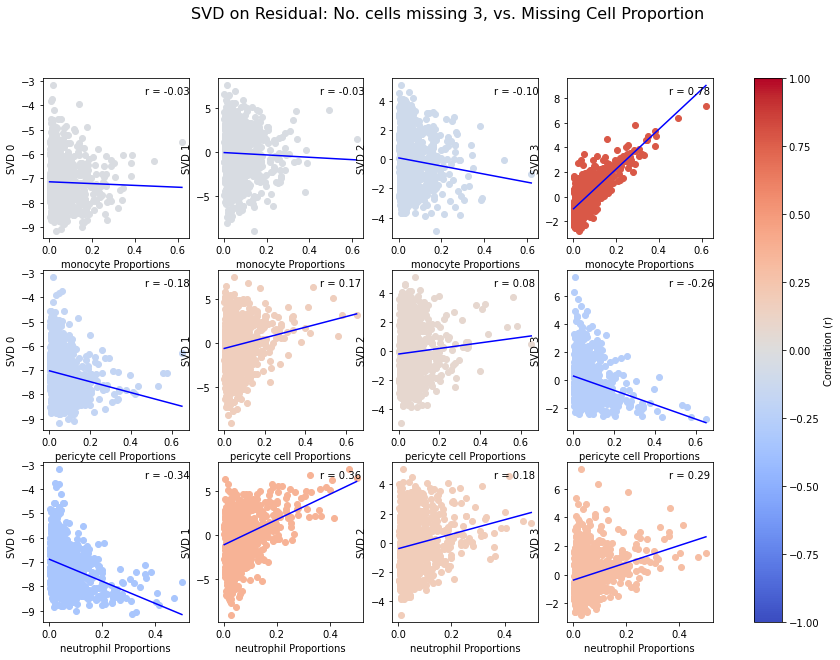

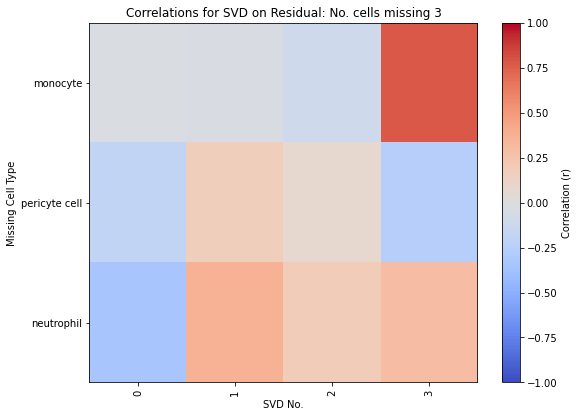

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


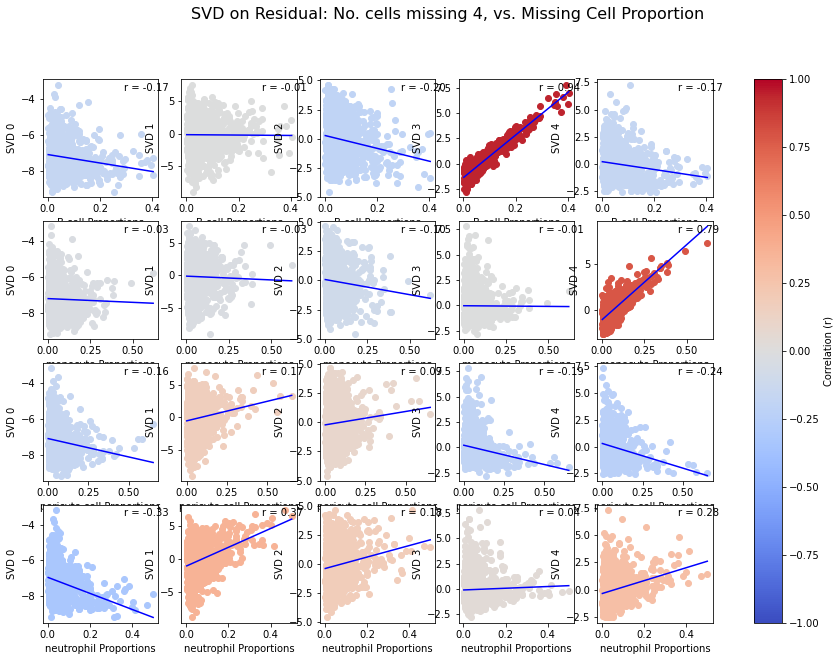

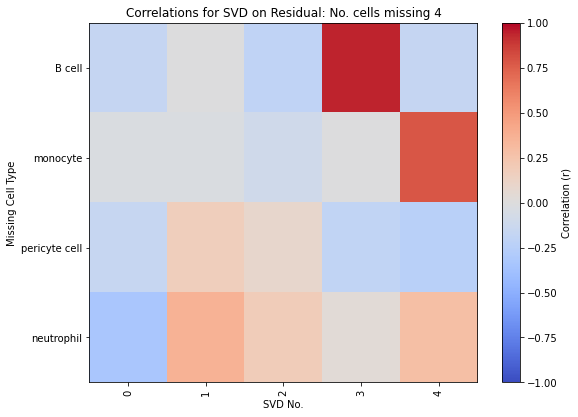

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


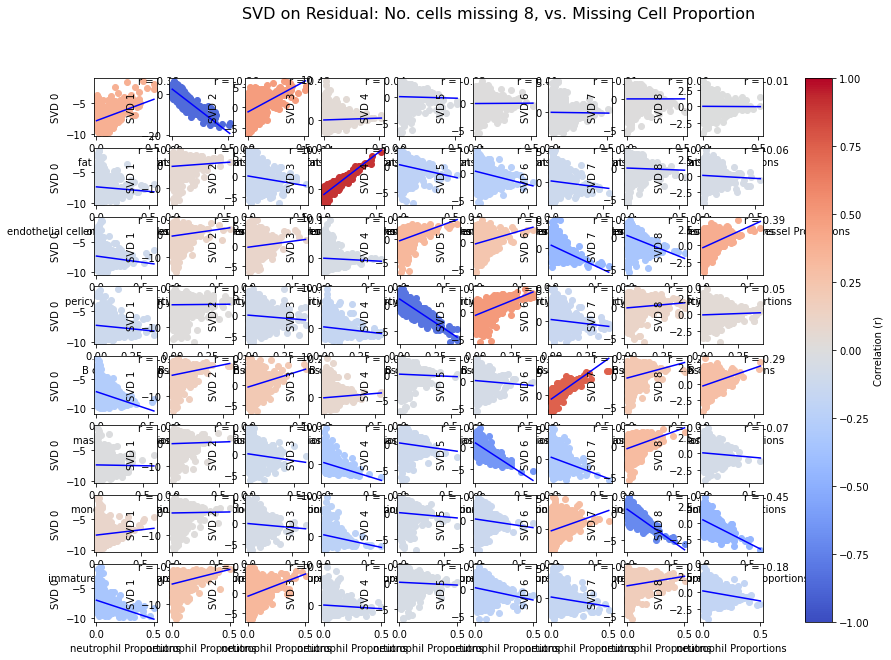

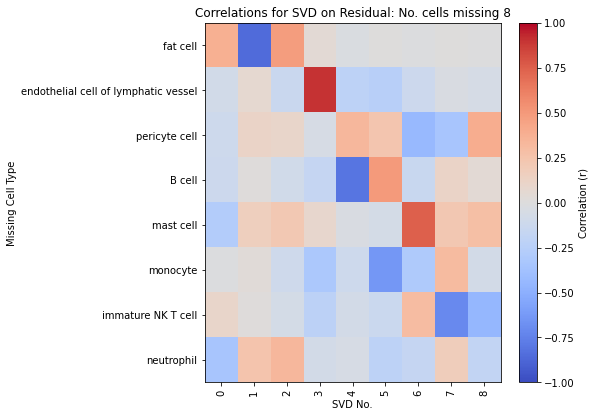

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


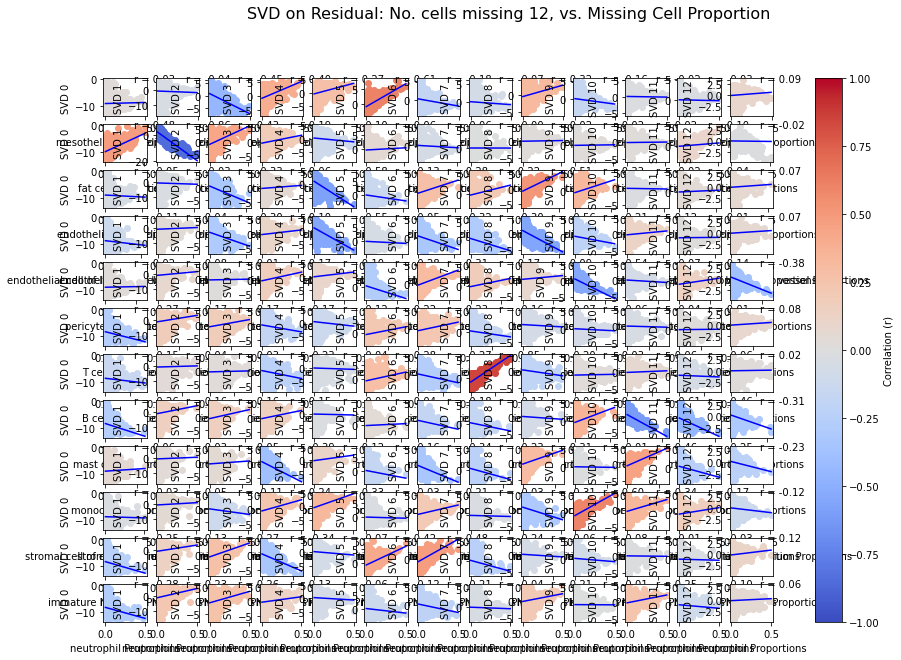

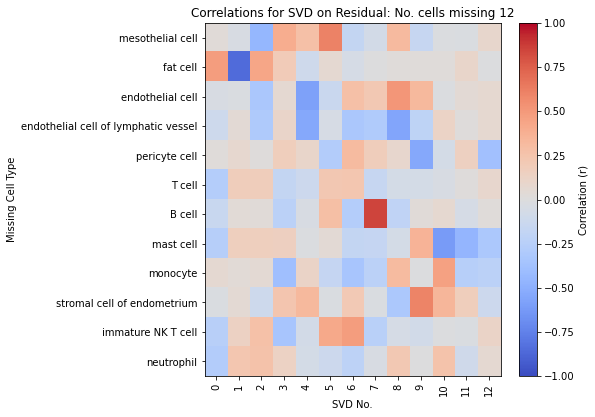

In [40]:
#SVD Residual(by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
vp.factors_vs_proportions_heatmaps(Recon_Mat_matchS, missing_cell_prop, num_missing_cells, "SVD") 
#Each missing cell's expression * proportion matrix is projected into the SVD's reconstructed matrix (just S * U).        

## **PCA**

Calculating PCA for each Residual and Percent of Variance Explained

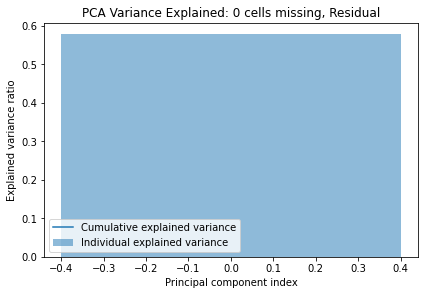

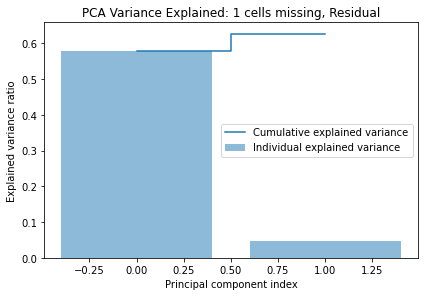

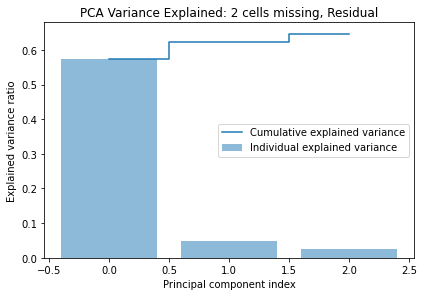

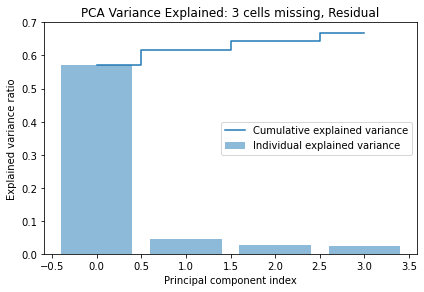

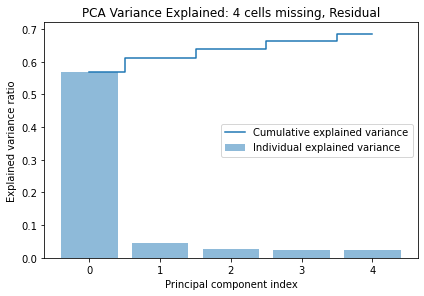

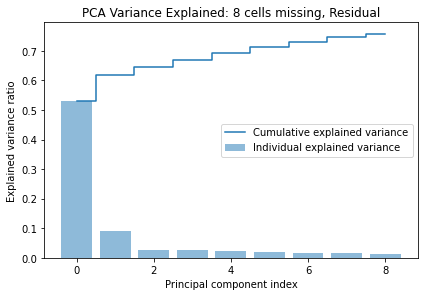

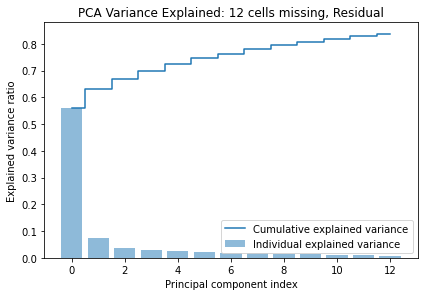

In [41]:
pca_res = dict()
for num in num_cells_missing:
    df = residuals[num].T #transposing to get length of genes instead of samples
    fit = PCA(n_components= num + 1)
    pca_results = fit.fit_transform(df.values)

    exp_var_pca = fit.explained_variance_ratio_
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)

    ## plot variance explained
    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.title(f"PCA Variance Explained: {num} cells missing, Residual")
    plt.show()
    pca_res[num] = pd.DataFrame(pca_results)

Analyzing PCA Results

Residual

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


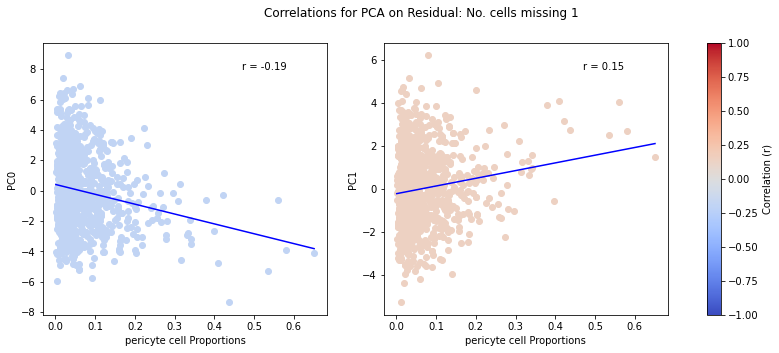

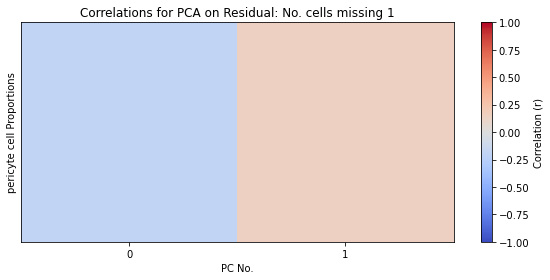

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


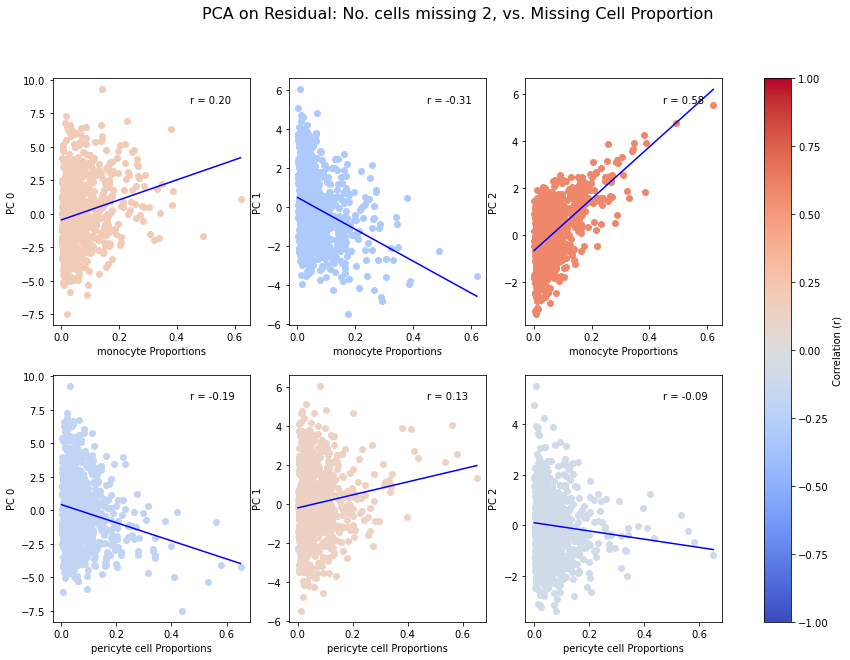

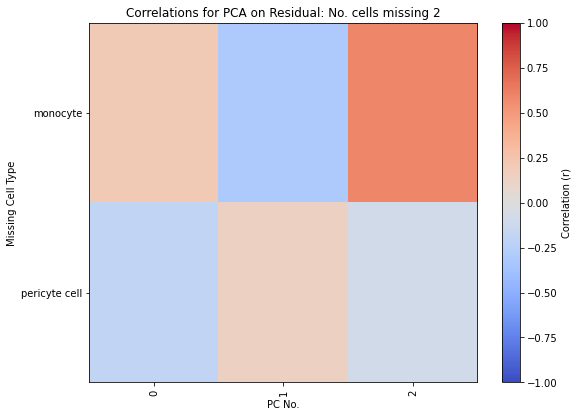

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


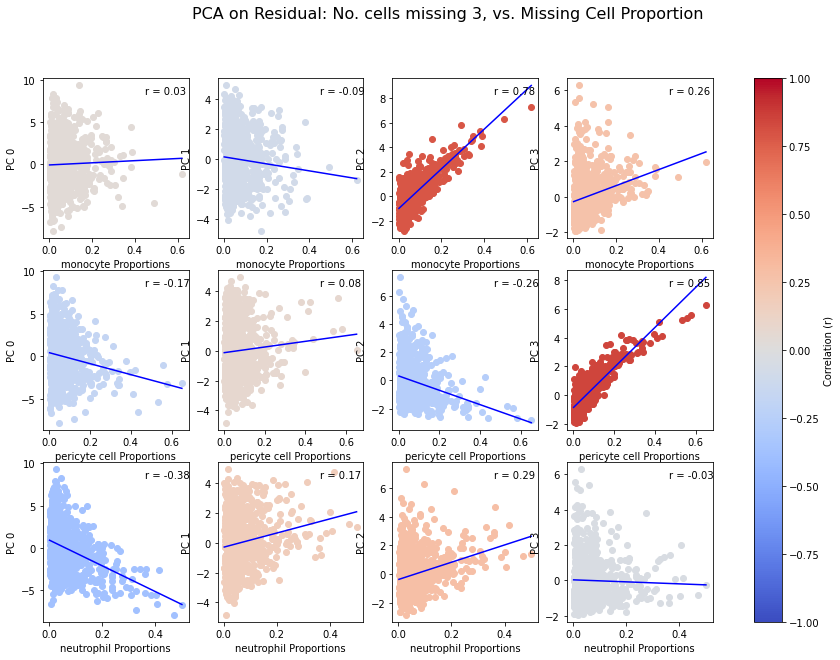

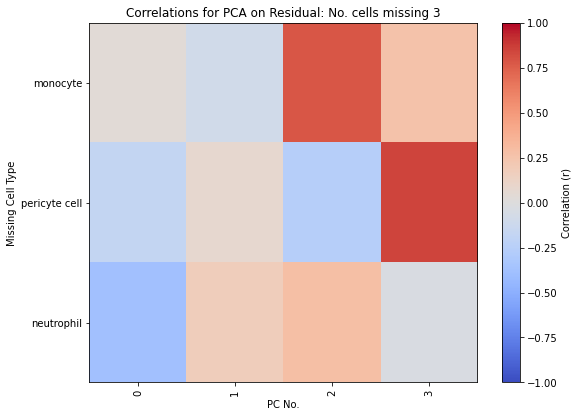

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


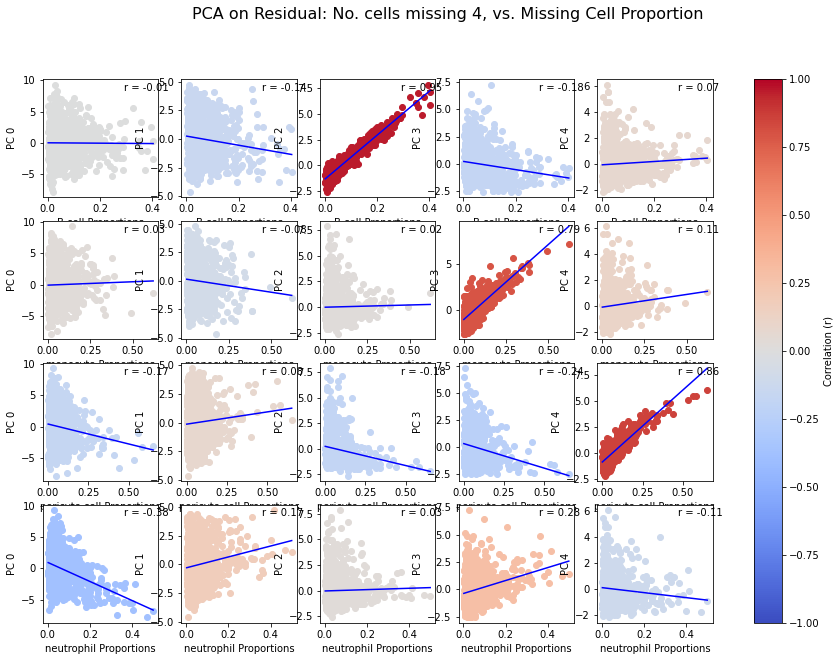

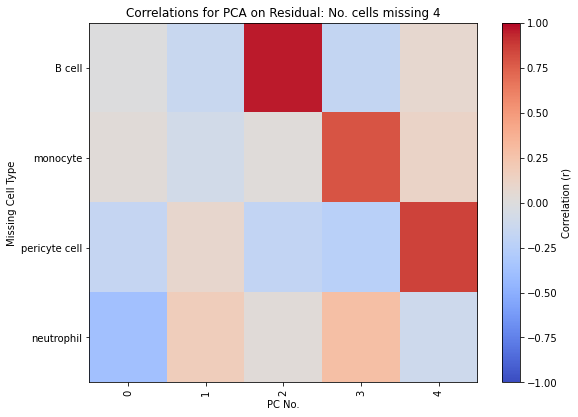

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


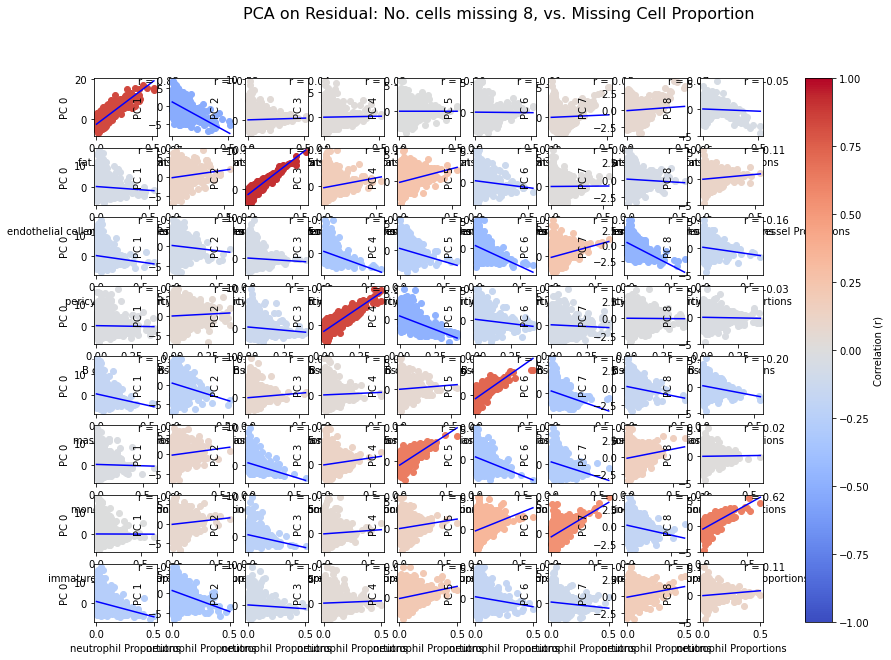

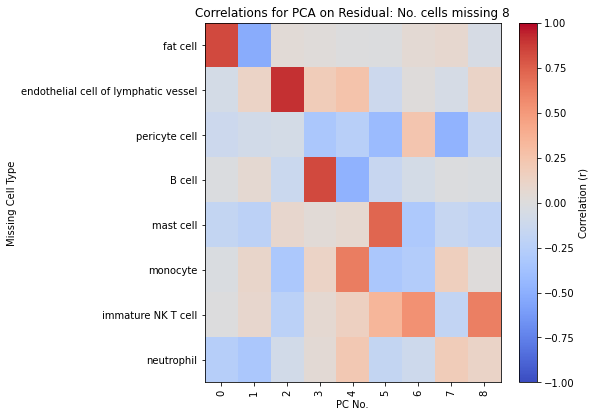

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


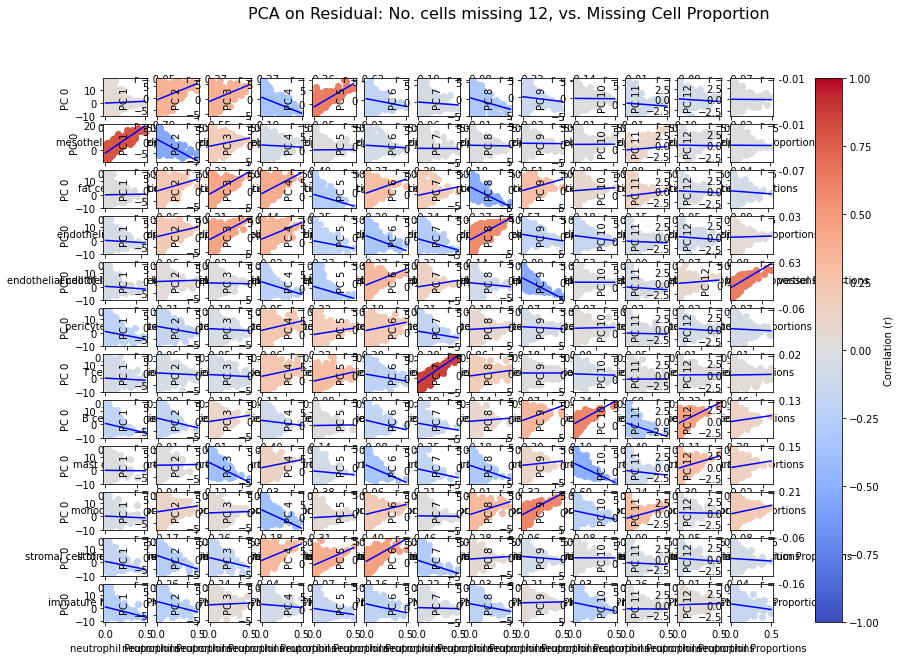

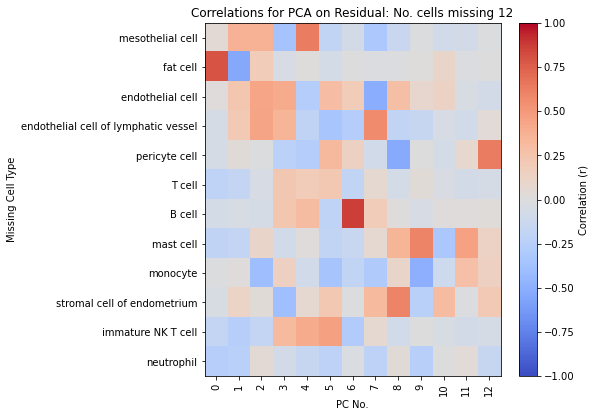

In [42]:
#PCA Residual(by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
res_pca_sample = dict()
for num in num_missing_cells[1:]:
    num_pca = num + 1
    pca = PCA(n_components = num_pca)
    res_pca_df = pca.fit_transform(residuals[num])
    res_pca_sample[num] = pd.DataFrame(res_pca_df)#each missing cell type expression with each Component
vp.factors_vs_proportions_heatmaps(res_pca_sample, missing_cell_prop, num_cells_missing, "PCA")

## **ICA**

Calculate ICA

In [43]:
#ICA on residual 1
res_ica = dict()
for num in num_missing_cells:
    num_ica = num + 1
    ica = FastICA(n_components = num_ica)
    res_ica_df = ica.fit_transform(residuals[num].T)
    res_ica_df = pd.DataFrame(res_ica_df)
    res_ica[num] = res_ica_df

Residual

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:116: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


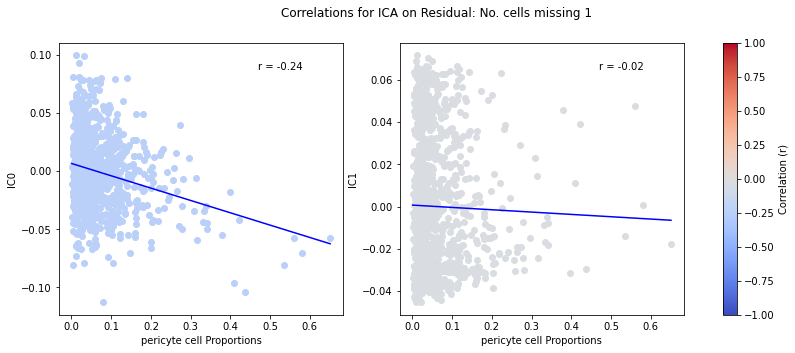

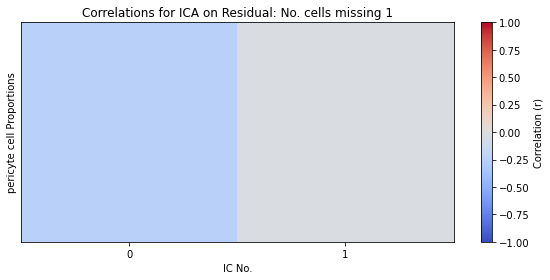

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


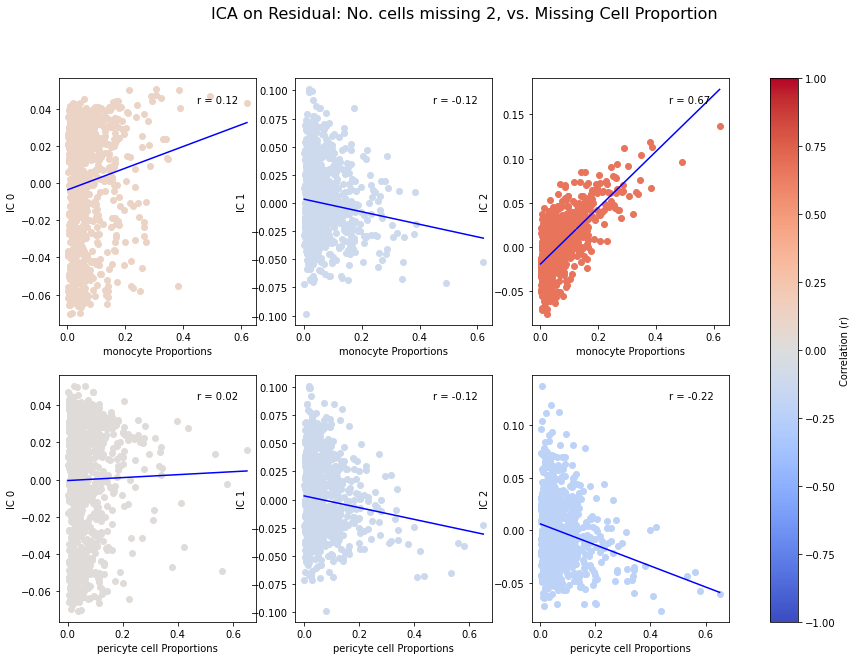

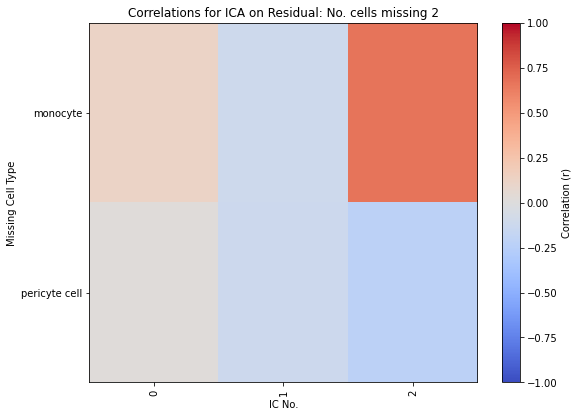

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


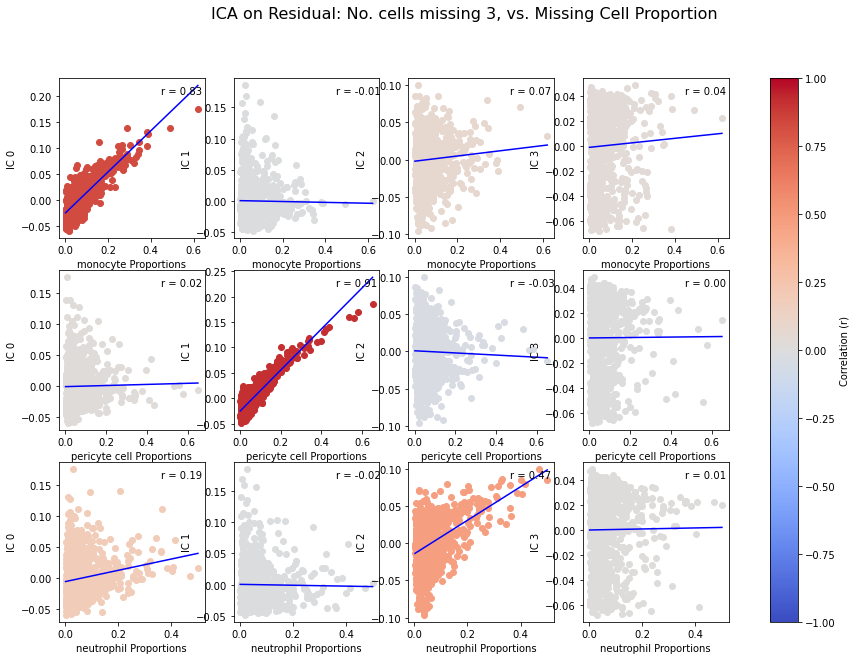

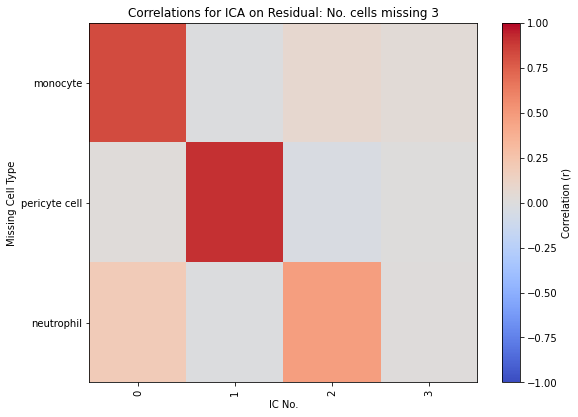

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


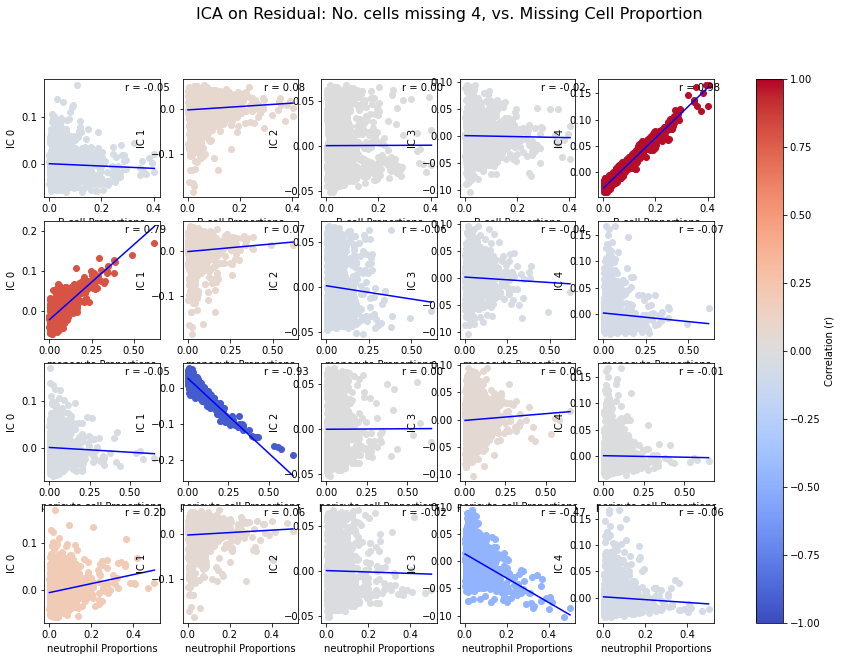

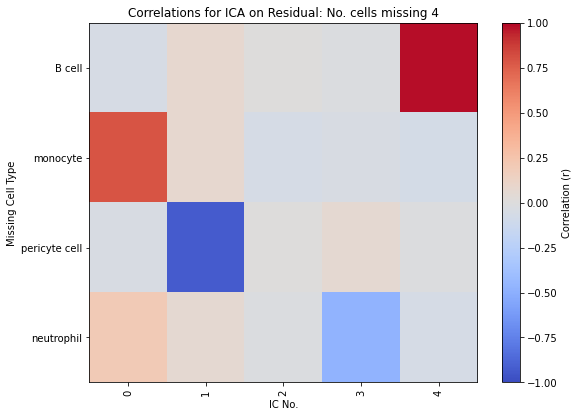

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


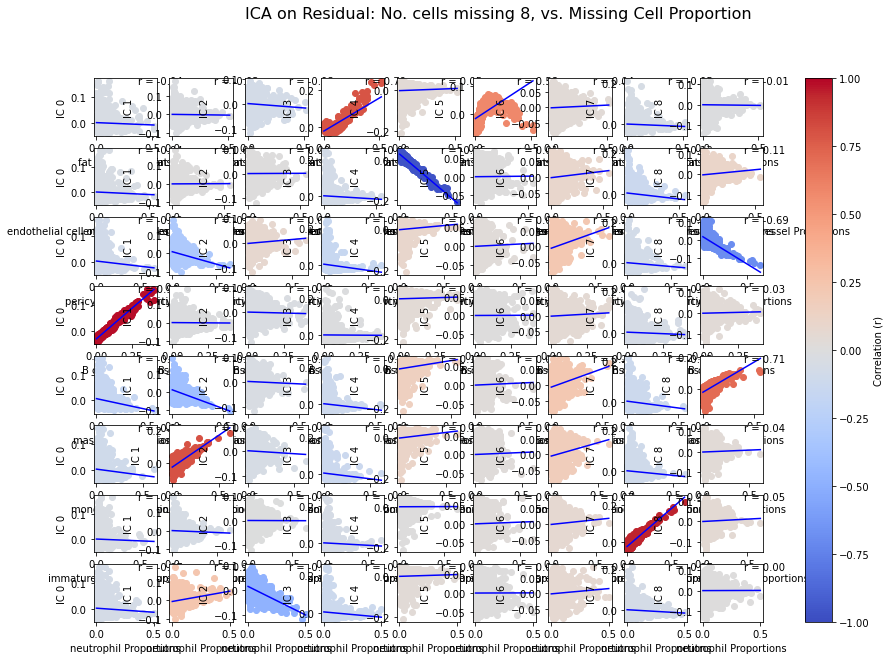

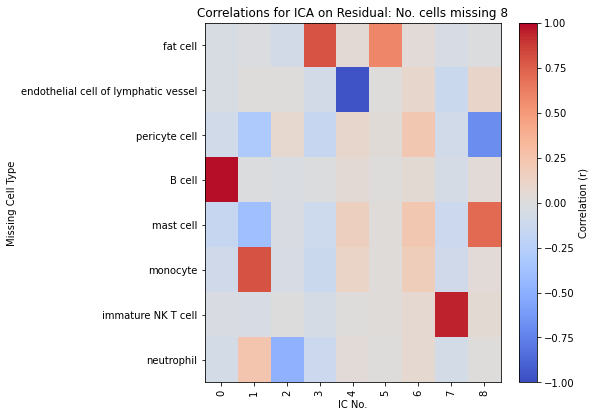

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


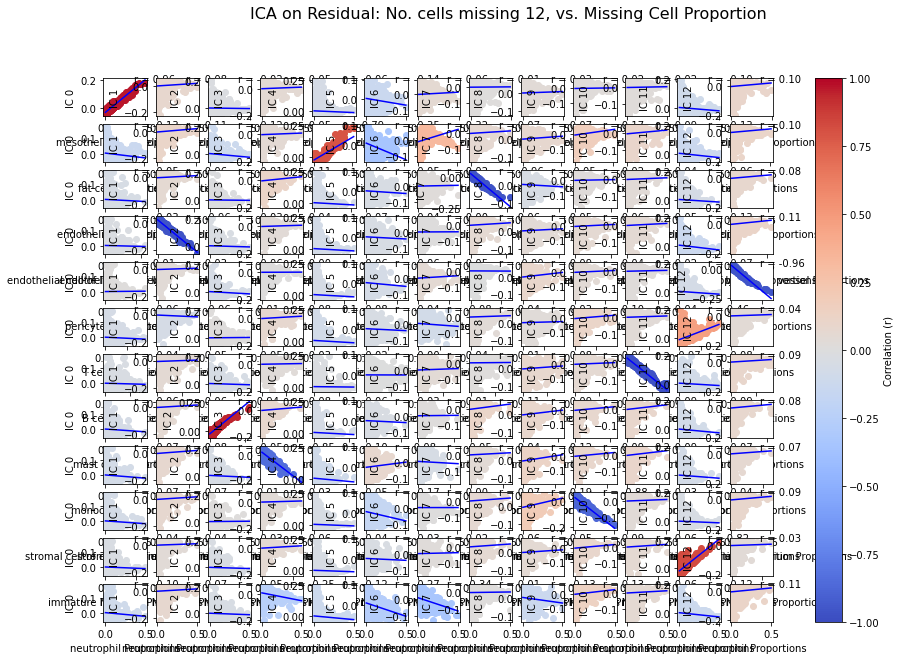

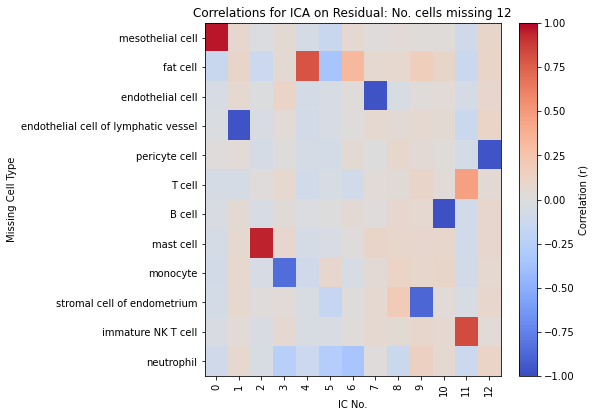

In [44]:
#ICA Residual (by sample) compared to each missing celltype proportion
# iterate over the number of missing cells
res_ICA_sample = dict()
for num in num_missing_cells[1:]:
    num_ICA = num + 1
    ica = FastICA(n_components = num_ICA)
    res_ICA_df = ica.fit_transform(residuals[num])
    res_ICA_sample[num] = pd.DataFrame(res_ICA_df)#each missing cell type expression with each Component
vp.factors_vs_proportions_heatmaps(res_ICA_sample, missing_cell_prop, num_cells_missing, "ICA")

## NMF

Analyzing how close to negative the distributions of each residual are:

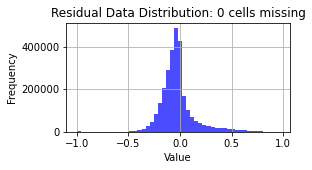

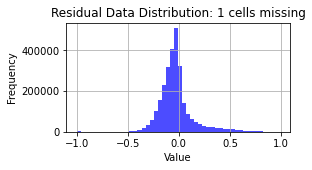

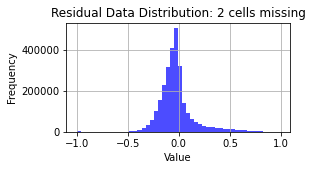

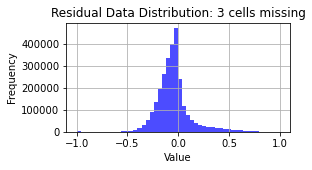

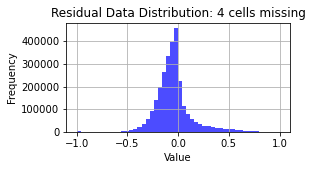

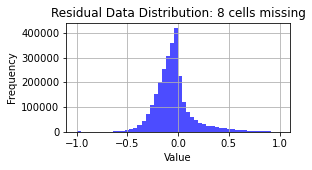

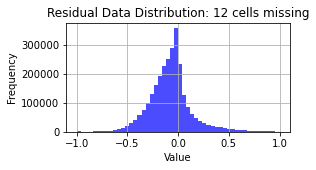

In [45]:
#distribution of residuals
for num in num_missing_cells:
    data = residuals[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

Shifting distributions according to above plots, and calculating NMF:

1.0000000000000002


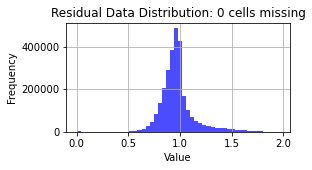

1.0000000000000002


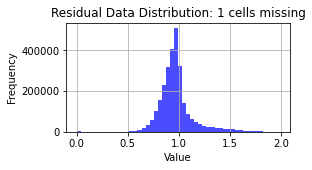

1.0000000000000002


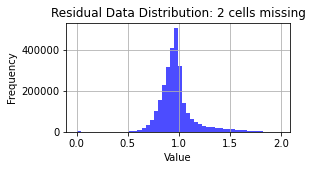

1.0000000000000002


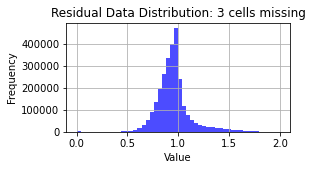

1.0000000000000002


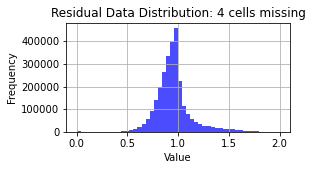

1.0000000000000002


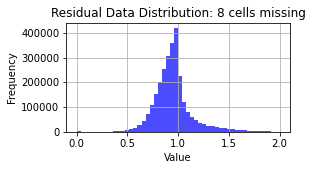

1.0000000000000002


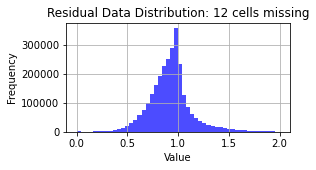

In [46]:
#shifting distribution of residuals to do NMF
residuals_shift = residuals
for num in num_missing_cells:
    if nmf_cut == "minimum_value":
        #calculate value to shift distributions minimally:
        min_val = abs(np.min(np.min(residuals[num])))
        print(min_val)
        residuals_shift[num] = residuals[num] + min_val
    elif nmf_cut == "at_0":
        #cutting distribution at 0
        residuals_shift[num][residuals_shift[num].values <= 0] = 0
    data = residuals_shift[num].values
    plt.figure(figsize=(4, 2)) 
    plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Residual Data Distribution: {num} cells missing')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [47]:
#nmf on residual 1
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf)
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Analyzing NMF Results:

Residual

/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(
/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


/Users/ivicha/opt/anaconda3/envs/env_ml/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 5000 reached. Increase it to improve convergence.
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


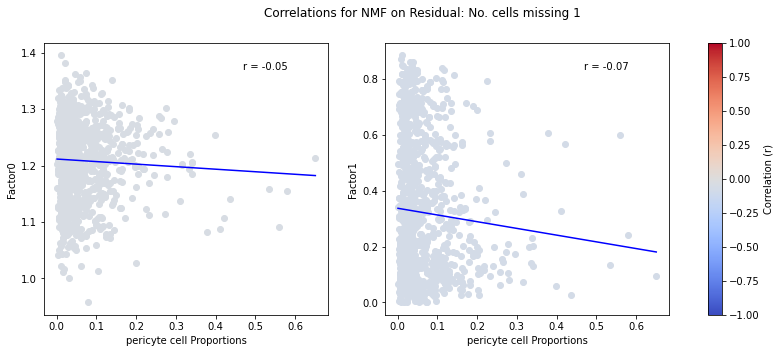

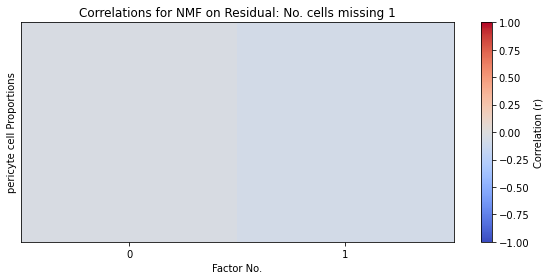

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


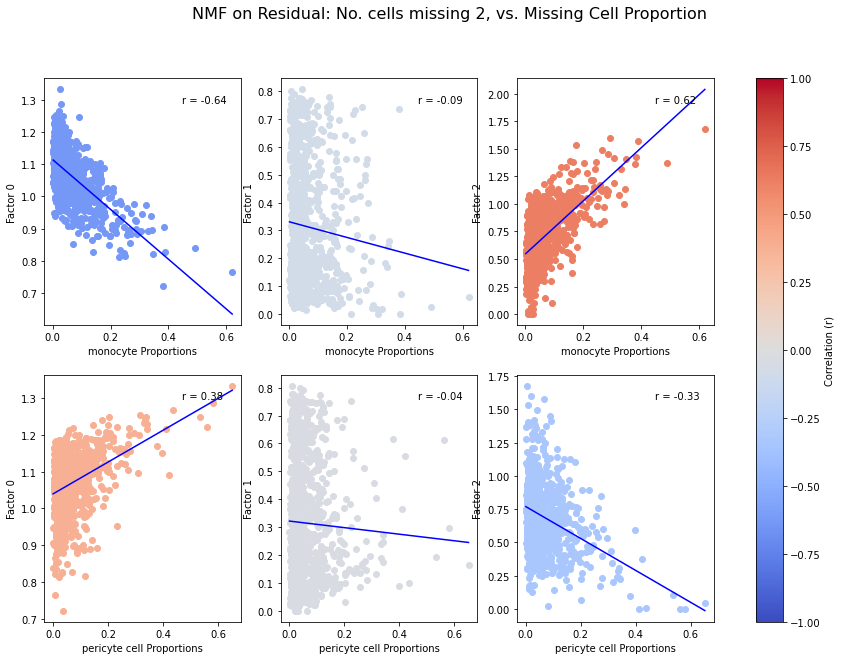

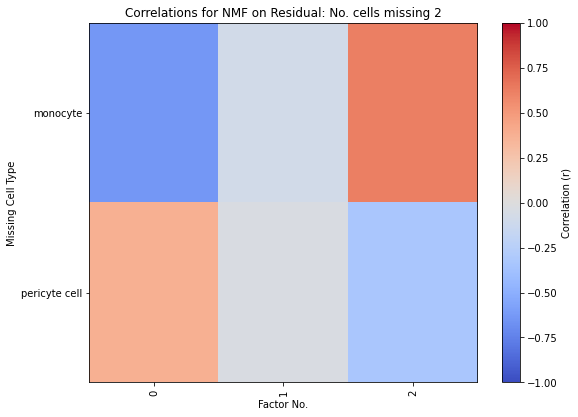

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


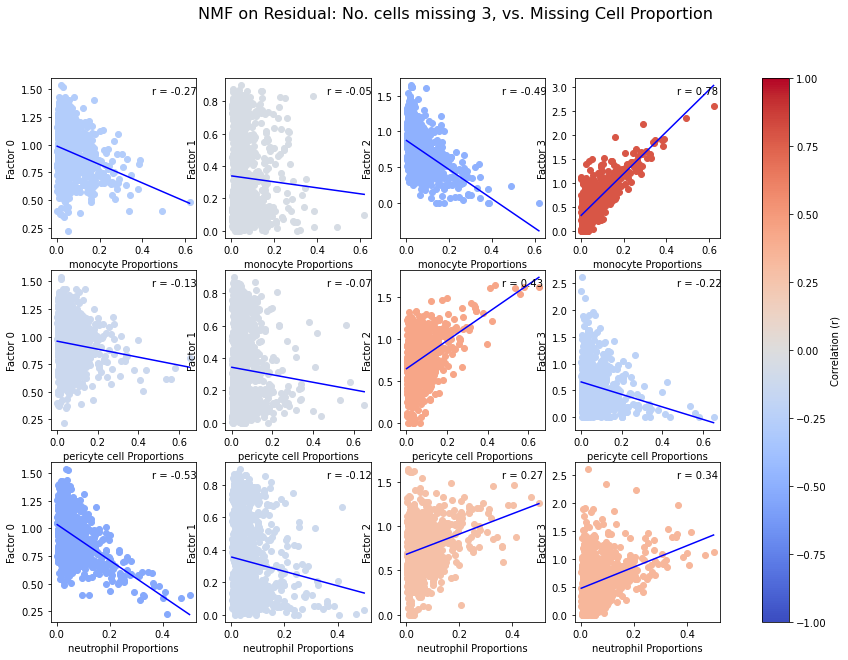

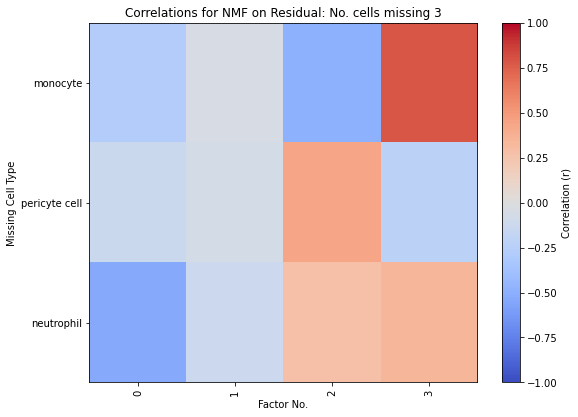

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


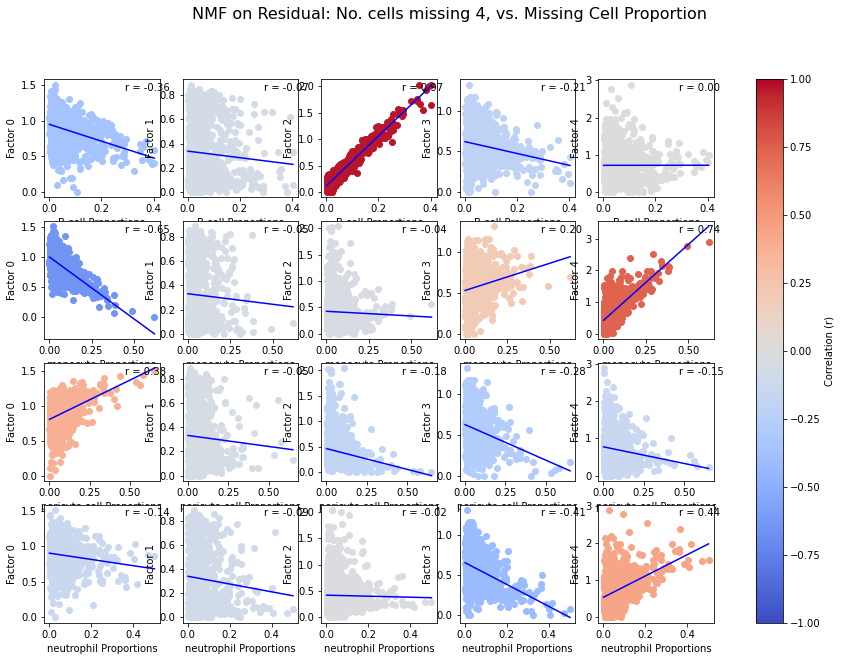

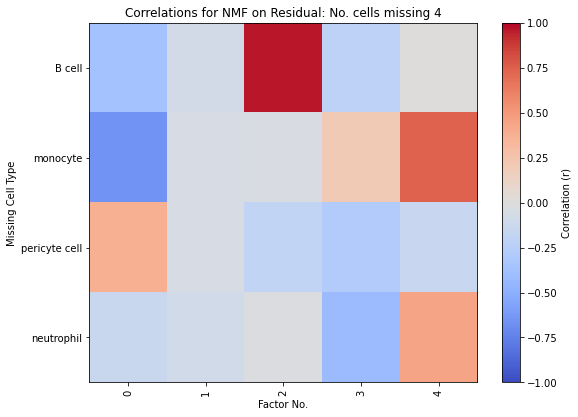

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


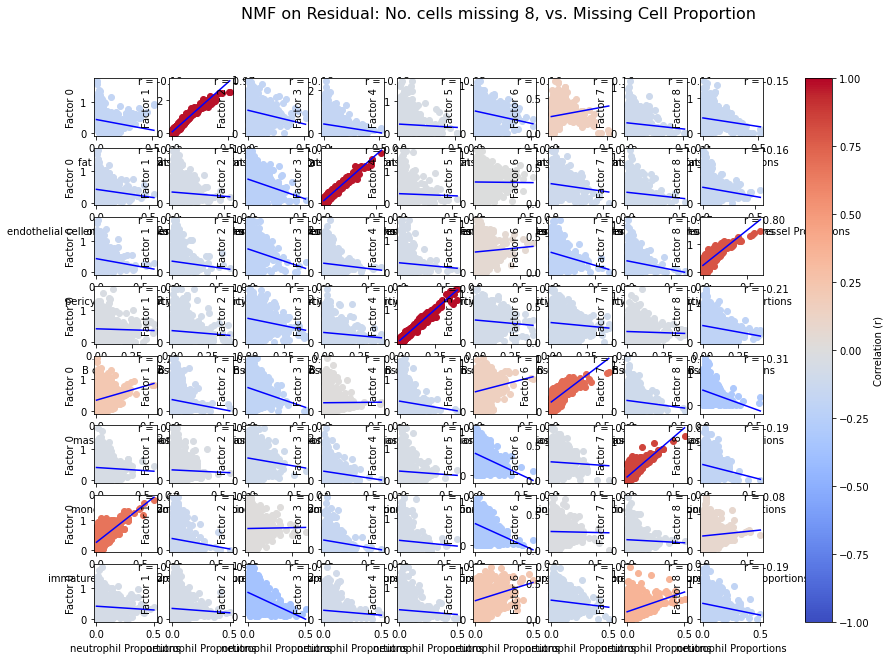

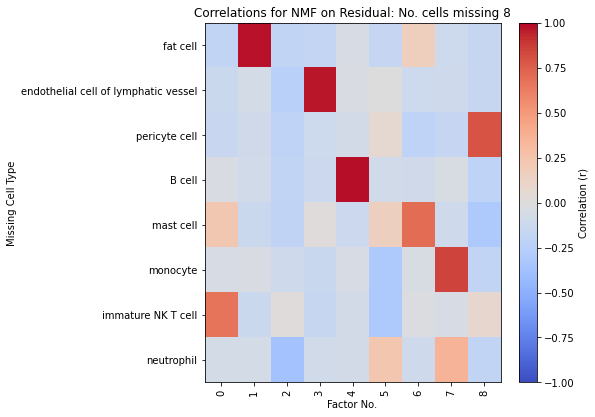

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


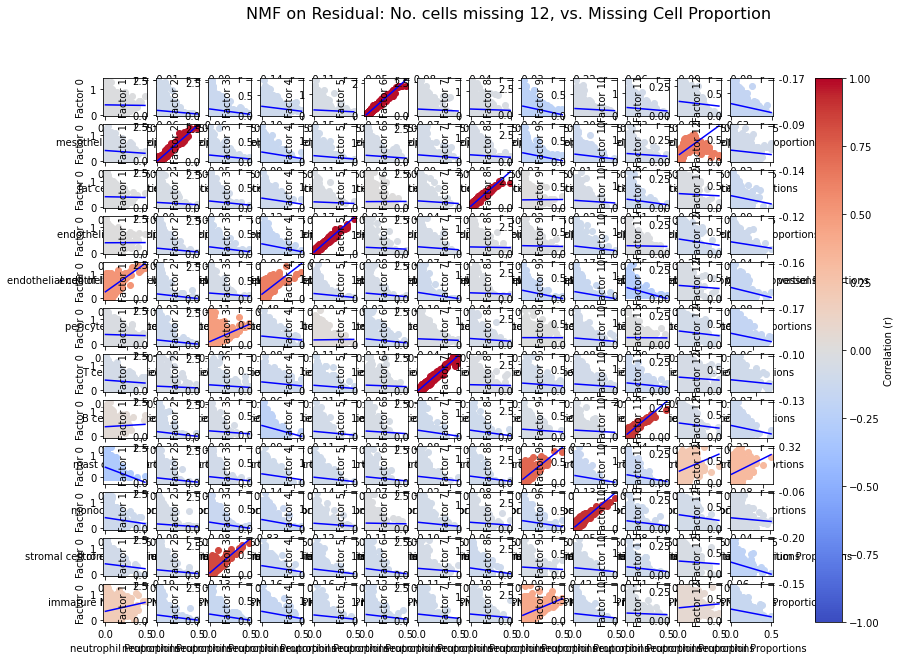

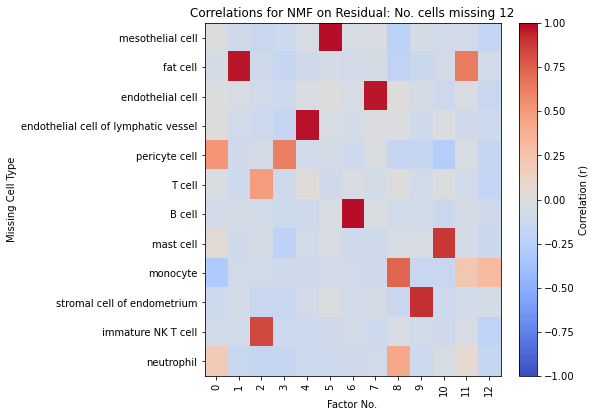

In [48]:
#NMF Residual(by sample) compared to each missing celltype proportion
#nmf on residual 1
res_nmf = dict()
for num in num_missing_cells:
    num_nmf = num +1
    nmf = NMF(n_components = num_nmf, max_iter = 5000)
    res_nmf_df = nmf.fit_transform(residuals_shift[num])
    res_nmf_df = pd.DataFrame(res_nmf_df)
    res_nmf[num] = res_nmf_df
vp.factors_vs_proportions_heatmaps(res_nmf, missing_cell_prop, num_missing_cells, method = "NMF")
#It is expected that only one column (factor) for each cell type (row) will be postivelly correlated. 